# Project: Investigate the Soccer DataSet

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime

In [2]:
# Increase the width of the notebook to use the 100% of the window.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [44]:
# This data is avaialable at https://drive.google.com/open?id=1eiMzjMO75BSHDhg-HdErlh0091k98Z4j
match_csv = pd.read_csv('../data/Eurpoean_Soccer_DB/Match_edited.csv')
team_csv = pd.read_csv('../data/Eurpoean_Soccer_DB/Team.csv')
player_csv = pd.read_csv('../data/Eurpoean_Soccer_DB/Player.csv')
#player_attrib_csv = pd.read_csv('./data/Eurpoean_Soccer_DB/Player_Attributes.csv')
player_attrib_csv = pd.read_csv('../data/Eurpoean_Soccer_DB/player_attributes_modified.csv')
pd.options.display.max_columns = None
match_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Columns: 115 entries, id to BSA
dtypes: float64(54), int64(51), object(10)
memory usage: 5.3+ MB


In [4]:
team_csv.head(2)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC


In [5]:
player_csv.head(2)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146


In [6]:
player_attrib_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 4 columns):
player_api_id     183977 non-null int64
player_name       183977 non-null object
overall_rating    183142 non-null float64
date              183977 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 5.6+ MB


In [7]:
player_attrib_csv.sample()

,player_api_id,player_name,overall_rating,date
129430,179810,Mustapha Dumbuya,52.0,2009-08-30 00:00:00


Questions:
After looking at the code following questions have come to the mind, this based on the knowledge on EPL.
We are assuming that a user selects a Season and Team to ask the following questions
1. Which team won the EPL for the selected season?
2. Which teams were releagated?
3. Which teams qualified for Champions League?
4. Top 5 scorers for the season.

The above questions can be answered with the Match.csv with presentational information from Team.csv and Player.csv.

5. Which team has won the most EPL across the seasons?
6. What is the overall rating of the top players?
This question will also need the Player_Attributes table data.

# Data Wrangling Phase/ Data Cleansing if required.
Taking only the releavent columns from the Match csv, remvoing the position and the betting related data as not
going to use this for analysis for now.

In [8]:
def get_player_overall_attribute(data, player_id, year_1, year_2):
    #print(player_attrib_csv)
    #player_attrib_modif = player_attrib_csv.iloc[:,np.r_[0, 2:5]].copy()
    if not isinstance(data['date'], datetime.datetime):
        data['date'] = pd.to_datetime(data['date'])
    print(data.info())
    data['year'], data['month'] = data['date'].dt.year, data['date'].dt.month
    #player_attrib_csv.info()
    data = data.loc[data['year'].isin([year_1, year_2])].query("player_api_id == " + player_id)
    if data.empty: 
        return '0.0' 
    else:
        return data['overall_rating'].mean()

In [9]:
get_player_overall_attribute(player_attrib_csv, '41688', 2015, 2016)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 4 columns):
player_api_id     183977 non-null int64
player_name       183977 non-null object
overall_rating    183142 non-null float64
date              183977 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.6+ MB
None


75.26666666666667

In [10]:
# Function that will filter by league and season
def filter_by_league_n_season(data,league_id, season_id):
    filter_league_df = match_csv[match_csv['league_id'] == league_id].copy()
    filter_season_df = filter_league_df[filter_league_df['season'] == season_id]
    names_col = filter_season_df[['id','home_player_1', 'home_player_2','home_player_3', 'home_player_4', 'home_player_5',
                          'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
                          'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
                          'away_player_5','away_player_6', 'away_player_7', 'away_player_8', 'away_player_9',
                          'away_player_10', 'away_player_11']].fillna(0).astype(int)
    #filter_match_details = filter_league_df.iloc[:,np.r_[0:11, 77:85]]
    filter_match_details = filter_season_df.iloc[:,0:11]
    #filter_by_col = filter_league_df.iloc[:,0:11].merge(names_col.iloc[:,0:23], left_on='id', right_on='id')
    filter_by_col = filter_match_details.merge(names_col, left_on='id', right_on='id')
    filter_by_col = filter_by_col.merge(filter_season_df.iloc[:,np.r_[0, 77:85]], left_on='id', right_on='id')
    return filter_by_col

# Data Exploration and Draw answers to questions

In [11]:
# Scenario 1: Limit to a Season and League and work around it
# -----------------------------------------------------------
#spanish_league = 21518
epl = 1729

season_id = '2009/2010'
next_season_id = '2010/2011'
league_id = epl
# This df is used in Visualzation using Plots
df = match_csv[match_csv['league_id'] == league_id].groupby('season')

data_for_analysis = filter_by_league_n_season(match_csv, league_id, season_id)
data_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 41 columns):
id                  380 non-null int64
country_id          380 non-null int64
league_id           380 non-null int64
season              380 non-null object
stage               380 non-null int64
date                380 non-null object
match_api_id        380 non-null int64
home_team_api_id    380 non-null int64
away_team_api_id    380 non-null int64
home_team_goal      380 non-null int64
away_team_goal      380 non-null int64
home_player_1       380 non-null int64
home_player_2       380 non-null int64
home_player_3       380 non-null int64
home_player_4       380 non-null int64
home_player_5       380 non-null int64
home_player_6       380 non-null int64
home_player_7       380 non-null int64
home_player_8       380 non-null int64
home_player_9       380 non-null int64
home_player_10      380 non-null int64
home_player_11      380 non-null int64
away_player_1       380 non-null in

In [12]:
data_for_analysis.sample()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
155,2264,1729,1729,2009/2010,23,2010-01-26 00:00:00,658961,8559,8191,1,0,23932,26454,23783,40128,34430,130670,35532,11576,24372,30753,23934,24788,34230,43252,23349,35437,23190,23185,21849,11496,38856,32627,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>49</comment><event...


In [13]:
sum(data_for_analysis.duplicated())

0

In [14]:
def calculate_home_teams_total_wins(team_id, data):
    counter = 0
    lost_count = 0
    goals_for = 0
    goals_against = 0
    filter_by_home_team = data[data['home_team_api_id'] == team_id]
    for index, row in filter_by_home_team.iterrows():
        #print(row['home_team_goal'], row['away_team_goal'])
        if row['home_team_goal'] > row['away_team_goal']:
            counter = counter + 3
            goals_for = goals_for + row['home_team_goal']
            goals_against = goals_against + row['away_team_goal']
        elif row['home_team_goal'] == row['away_team_goal']:
            counter = counter + 1
            goals_for = goals_for + row['home_team_goal']
            goals_against = goals_against + row['away_team_goal']
        else :
            #print("The home team lost this match")
            goals_for = goals_for + row['home_team_goal']
            goals_against = goals_against + row['away_team_goal']
            lost_count = lost_count + 1
    return counter, lost_count ,  goals_for,  goals_against    

In [15]:
def calculate_away_teams_total_wins(team_id, data):
    counter = 0
    lost_count = 0
    goals_for = 0
    goals_against = 0
    filter_by_away_team = data[data['away_team_api_id'] == team_id]
    for index, row in filter_by_away_team.iterrows():
        #print(row['home_team_goal'], row['away_team_goal'])
        if row['home_team_goal'] < row['away_team_goal']:
            counter = counter + 3
            goals_for = goals_for + row['away_team_goal']
            goals_against = goals_against + row['home_team_goal']
        elif row['home_team_goal'] == row['away_team_goal']:
            counter = counter + 1
            goals_for = goals_for + row['away_team_goal']
            goals_against = goals_against + row['home_team_goal']
        else :
            #print("The away team lost this match")
            lost_count = lost_count + 1
            goals_for = goals_for + row['away_team_goal']
            goals_against = goals_against + row['home_team_goal']
    return counter , lost_count , goals_for  , goals_against 

In [16]:
# calculate the winner for a particular season:
def calculate_winner_season(data):
    team_scores = {}
    total_goal_for = {}
    total_goal_ag = {}
    for index, all_data in data.iterrows():
        team_id = all_data['home_team_api_id']
        #print('team for processing is {0}'.format(team_id))
        count_home, lost_count_home, goal_for_h, goal_ag_h = calculate_home_teams_total_wins(team_id, data)
        #print(count_home)
        count_away, lost_count_away, goal_for_a, goal_ag_a = calculate_away_teams_total_wins(team_id, data)
        #print(count_away)
        total_count = count_home + count_away
        total_matches_lost = lost_count_home + lost_count_away
        team_scores[team_id] = total_count
        total_goal_for[team_id] = goal_for_h + goal_for_a
        total_goal_ag[team_id] = goal_ag_h + goal_ag_a
        #print("{0} = {1}".format(team_id, total_count))
        #print('Total matches lost is {0}'.format(total_matches_lost))
    return team_scores, total_goal_for, total_goal_ag    

In [17]:
def mergeDict(source_dict, dest_dict):
    for k,v in source_dict.items():
        if k not in dest_dict.keys():
            dest_dict[k] = v
        elif k in dest_dict.keys():
            count = dest_dict[k]
            dest_dict[k] = count + v
    return dest_dict

In [18]:
import xml.etree.ElementTree as ET

def parseXML(goal_xml_string):
    # create element tree object
    tree = ET.fromstring(goal_xml_string)
    # create empty disctionary for players count
    players = {}
    # iterate news items
    for item in tree:
        #print("1::", item)
        # iterate child elements of item
        for child in item:
            #print("2::", child)
            # Check only for goals with n and p
            if child.tag == 'comment':
                goal_type = child.text
            if child.tag == 'player1':
                #print('player 1 found')
                players1 = child.text
                #print(' The players dictionary is {}'.format(players))
                #print(' The penalty dictionary is {}'.format(penalty))
                #print('goal_type ', goal_type)
                if goal_type in ('n', 'p'):
                    if players1 in players.keys():
                        count = players[players1]
                        players[players1] = count + 1
                    else:
                        players[players1] = 1
    # return dataframe of players of list of goal scorers for a match
    return players

In [19]:
# This will be for a season for a league:
def calculate_top_scorer(data):
    top_goal_scores = {}
    top_penalty_scores = {}
    for index, all_data in data.iterrows():
        goal_xml_string = all_data['goal']
        #print(all_data['match_api_id'])
        if pd.isnull(goal_xml_string):
            continue
        dict_scores_for_match = parseXML(goal_xml_string)
        top_goal_scores = mergeDict(dict_scores_for_match, top_goal_scores)
        #top_penalty_scores = mergeDict(penalty, top_penalty_scores)
        #print("2: ", top_goal_scores)
    return top_goal_scores

In [20]:
def merge_all_dictionary_to_df(team_scores, total_goals_for, total_goals_ag):
    team_scores_1 = pd.DataFrame.from_dict(team_scores, orient='index')
    team_scores_2 = pd.DataFrame.from_dict(total_goals_for, orient='index')
    team_scores_3 = pd.DataFrame.from_dict(total_goals_ag, orient='index')
    team_scores_4 = team_scores_1.merge(team_scores_2, left_index=True, right_index=True)
    #team_scores_4 = team_scores_4.rename(columns={"0_x": "Score", "0_y": "Goals_For"})
    #print(team_scores_4)
    team_scores_5 = team_scores_4.merge(team_scores_3, left_index=True, right_index=True)
    #team_scores_5 = team_scores_5.rename(columns={"0": "Goals_Against"})
    team_scores_5.columns = ['Score', 'Goals_For', 'Goals_Against']
    #print(team_scores_5)
    team_scores_5 = team_scores_5.sort_values(by=['Score', 'Goals_For', 'Goals_Against' ], ascending=False)
    return team_scores_5

In [21]:
#Calculate the top wining team for a season in a league.
def process_winner(data_for_analysis):
    team_scores, total_goals_for, total_goals_ag = calculate_winner_season(data_for_analysis)
    #team_scores, total_goals_for, total_goals_ag
    total_score_df = merge_all_dictionary_to_df(team_scores,total_goals_for,total_goals_ag)
    #total_score_df.sort_values(by=['Score', 'Goals_For', 'Goals_Against' ], ascending=False)
    return total_score_df

In [22]:
team_scores = process_winner(data_for_analysis)
team_scores

,Score,Goals_For,Goals_Against
8455,86,103,32
10260,85,86,28
9825,75,83,41
8586,70,67,41
8456,67,73,45
10252,64,52,39
8650,63,61,35
8668,61,60,49
8655,50,41,55
8658,50,38,47


In [23]:
order_team = []
#for values in sorted(team_scores, key=team_scores.get, reverse=True):
#    order_team.append(values)
order_team = team_scores.index.tolist()
print(team_csv[team_csv['team_api_id'] == order_team[0]]['team_long_name'].to_string(index=False) + " = " + str(team_scores.Score.iloc[0]))

Chelsea = 86


# Conclusions

In [24]:
team_info = team_csv[team_csv['team_api_id'] == order_team[0]]
print('The team that won the {} league is {}.'.format(season_id, team_info['team_long_name'].to_string(index=False)))

The team that won the 2009/2010 league is Chelsea.


In [25]:
team_info_last = team_csv[team_csv['team_api_id'] == order_team[-1]]
team_info_2ndlast = team_csv[team_csv['team_api_id'] == order_team[-2]]
team_info_3rdlast = team_csv[team_csv['team_api_id'] == order_team[-3]]

print('The teams that were relegated were {} in this order for season {}.  '
          .format([team_info_3rdlast['team_long_name'].to_string(index=False),
                   team_info_2ndlast['team_long_name'].to_string(index=False),
                   team_info_last['team_long_name'].to_string(index=False)], season_id))

The teams that were relegated were ['Burnley', 'Hull City', 'Portsmouth'] in this order for season 2009/2010.  


In [26]:
team_info = team_csv[team_csv['team_api_id'] == order_team[0]]
team_info_2nd = team_csv[team_csv['team_api_id'] == order_team[1]]
team_info_3rd = team_csv[team_csv['team_api_id'] == order_team[2]]
#team_info_4th = team_csv[team_csv['team_api_id'] == order_team[3]]

print('The teams that qualified for Champions League for the next season were \n {} \n for season {}.'.format(
[
    team_info['team_long_name'].to_string(index=False),
    team_info_2nd['team_long_name'].to_string(index=False),
    team_info_3rd['team_long_name'].to_string(index=False)
    #team_info_4th['team_long_name'].to_string(index=False)
], next_season_id

))

The teams that qualified for Champions League for the next season were 
 ['Chelsea', 'Manchester United', 'Arsenal'] 
 for season 2010/2011.


In [27]:
top_scorer_dict = calculate_top_scorer(data_for_analysis)

In [28]:
# Sort the data in the dictionary to calculate the top scorer, top five scorer.
order_player_id = []
order_player_score = []
for values in sorted(top_scorer_dict, key=top_scorer_dict.get, reverse=True):
    order_player_id.append(int(values)) ,  order_player_score.append(top_scorer_dict[values])    

In [29]:
order_player_id[0], order_player_score[0]

(30822, 29)

In [30]:
record = player_csv[player_csv['player_api_id'] == order_player_id[0]]
print('The player who has the hit maximum goals for {} season is {}.'.format(season_id, record['player_name'].to_string(index=False)))

The player who has the hit maximum goals for 2009/2010 season is Didier Drogba.


In [31]:
player_info = player_csv[player_csv['player_api_id'] == order_player_id[0]]
player_info_2nd = player_csv[player_csv['player_api_id'] == order_player_id[1]]
player_info_3rd = player_csv[player_csv['player_api_id'] == order_player_id[2]]
player_info_4th = player_csv[player_csv['player_api_id'] == order_player_id[3]]
player_info_5th = player_csv[player_csv['player_api_id'] == order_player_id[4]]

print('The player that scored the max goals for {} season were \n {}.'.format(season_id,
[
    str(order_player_id[0]) + " - " + player_info['player_name'].to_string(index=False) + '--' + str(order_player_score[0]),
    str(order_player_id[1]) + " - " + player_info_2nd['player_name'].to_string(index=False) + '--' + str(order_player_score[1]),
    str(order_player_id[2]) + " - " + player_info_3rd['player_name'].to_string(index=False) + '--' + str(order_player_score[2]),
    str(order_player_id[3]) + " - " + player_info_4th['player_name'].to_string(index=False) + '--' + str(order_player_score[3]),
    str(order_player_id[4]) + " - " + player_info_5th['player_name'].to_string(index=False) + '--' + str(order_player_score[4])
]

))

The player that scored the max goals for 2009/2010 season were 
 ['30822 - Didier Drogba--29', '30829 - Wayne Rooney--26', '23949 - Darren Bent--24', '38817 - Carlos Tevez--23', '30631 - Frank Lampard--22'].


# Visualzation using Plots

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#### Check for what league this data is being plotted at step 490.
df = match_csv[match_csv['league_id'] == league_id].groupby('season')
keys, value = zip(*df)

In [33]:
def convert_id_2_Name(list_of_name, type):
    if type == 'player':
        name_list = [player_csv[player_csv['player_api_id'] == int(elem)]['player_name'].
                                                              to_string(index=False) for elem in list_of_name]
    else:    
        name_list = [team_csv[team_csv['team_api_id'] == elem]['team_long_name'].
                                                                to_string(index=False) for elem in list_of_name]
    
    return name_list

       Score  Goals_For  Goals_Against
10260     90         68             24
The top team is Manchester United for season 2008/2009
      Score  Goals_For  Goals_Against
8455     86        103             32
The top team is Chelsea for season 2009/2010
       Score  Goals_For  Goals_Against
10260     80         78             37
The top team is Manchester United for season 2010/2011
      Score  Goals_For  Goals_Against
8456     89         93             29
The top team is Manchester City for season 2011/2012
       Score  Goals_For  Goals_Against
10260     89         86             43
The top team is Manchester United for season 2012/2013
      Score  Goals_For  Goals_Against
8456     86        102             37
The top team is Manchester City for season 2013/2014
      Score  Goals_For  Goals_Against
8455     87         73             32
The top team is Chelsea for season 2014/2015
      Score  Goals_For  Goals_Against
8197     81         68             36
The top team is Leicester

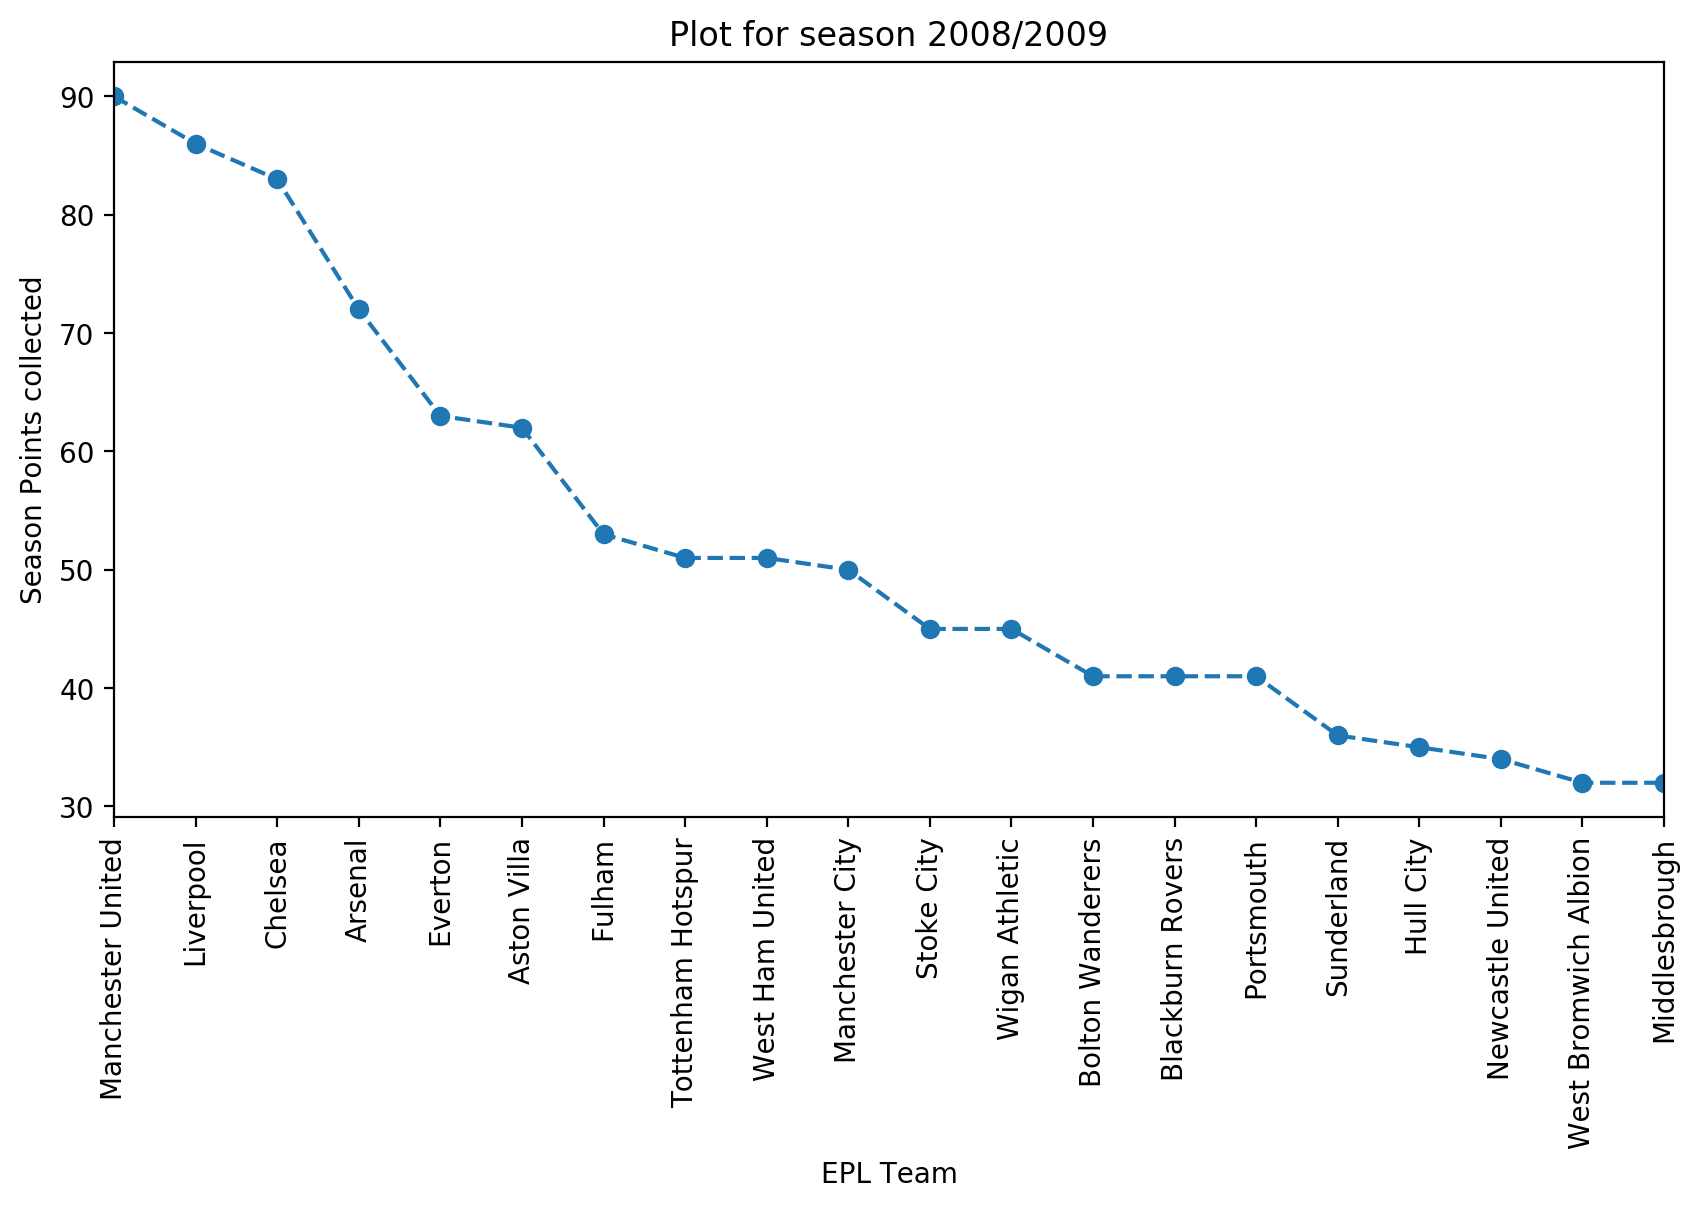

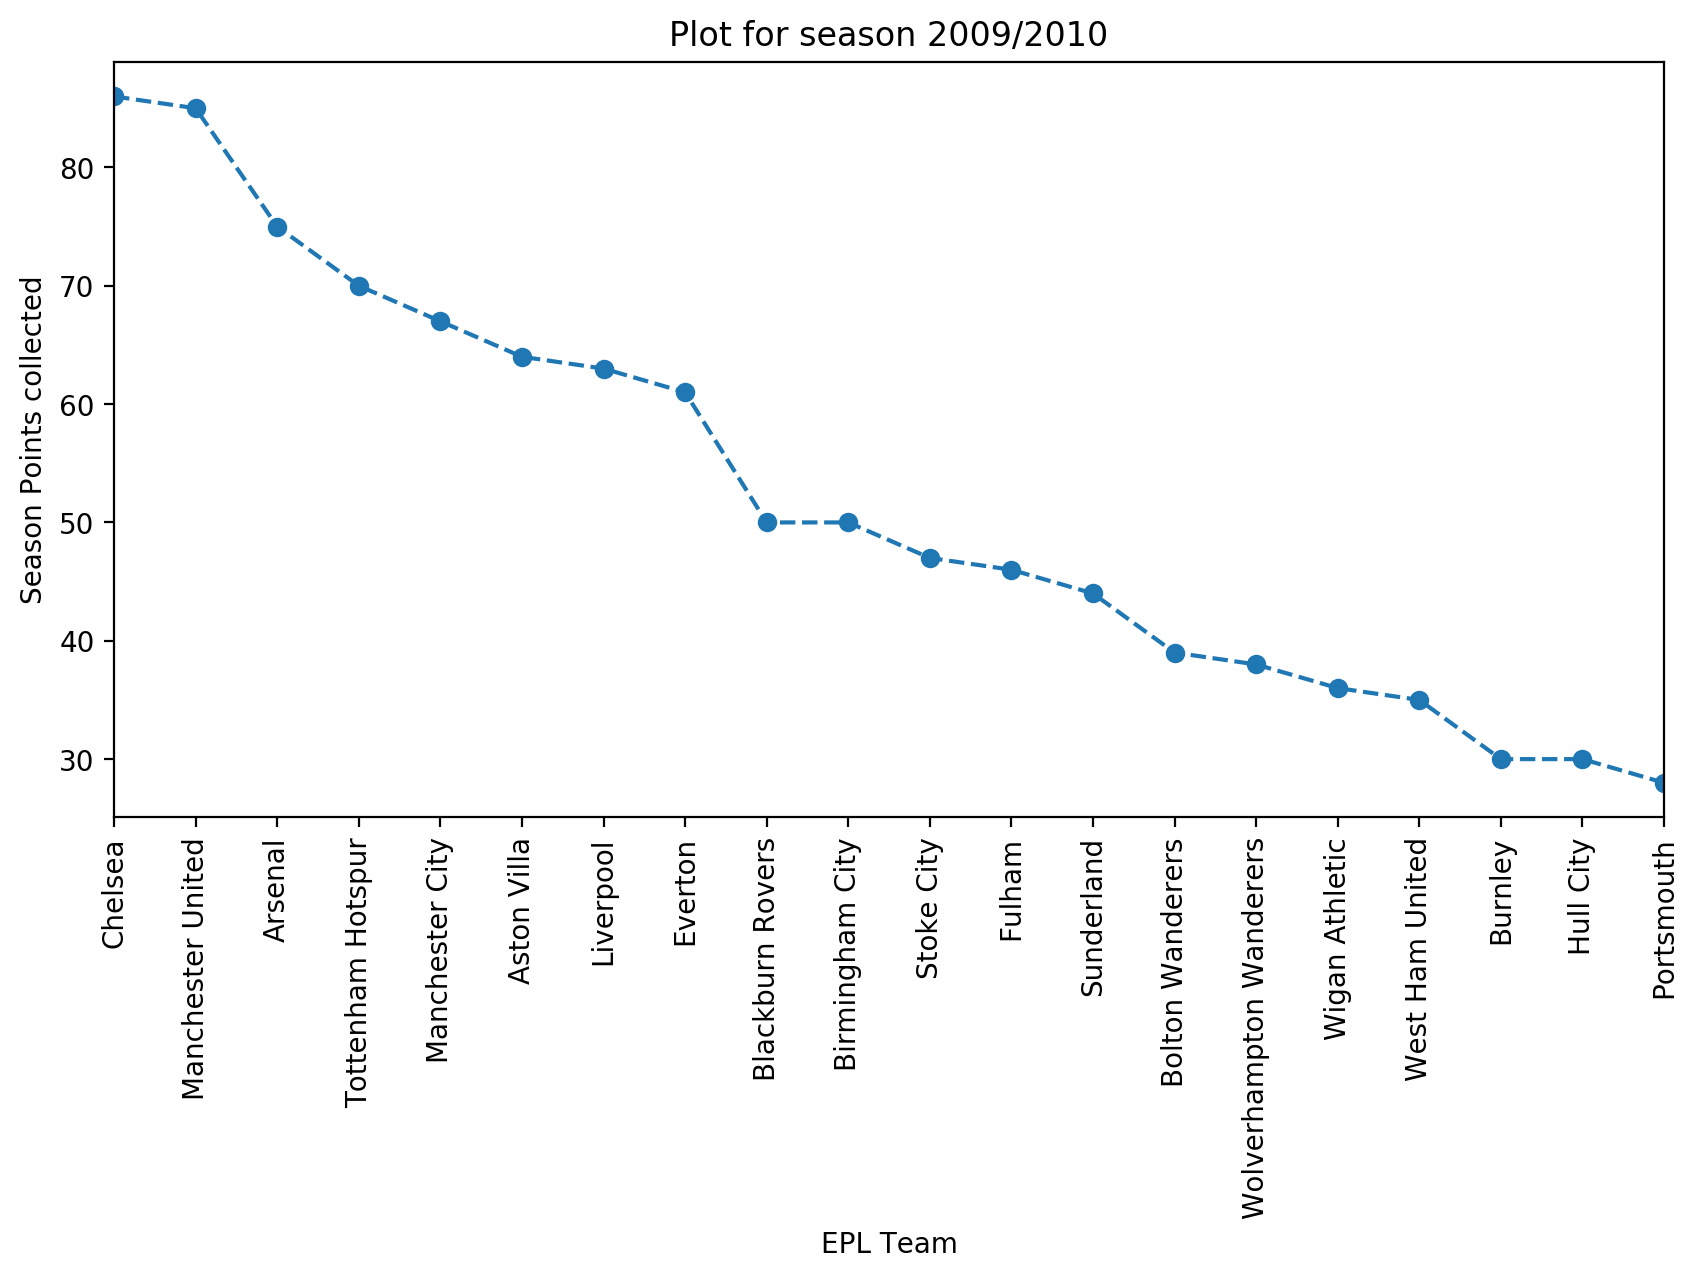

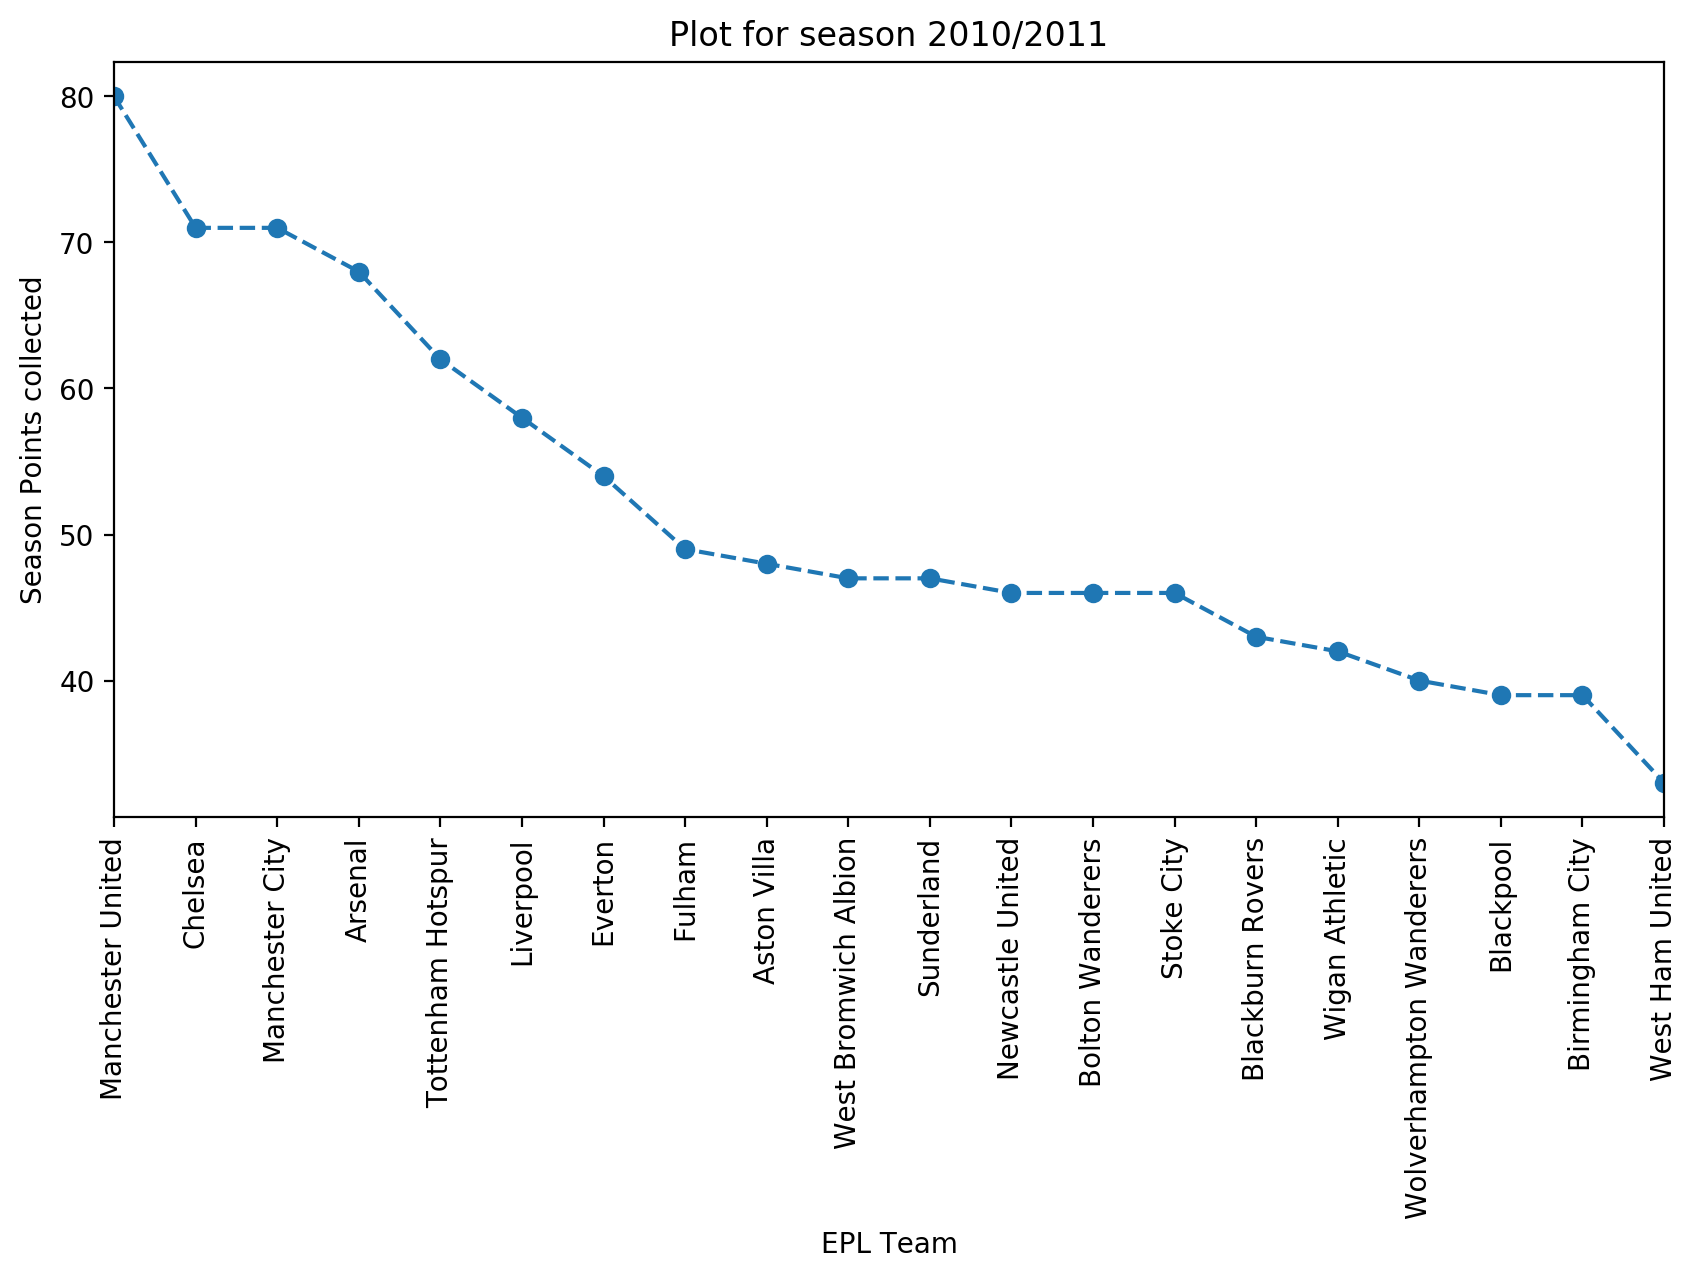

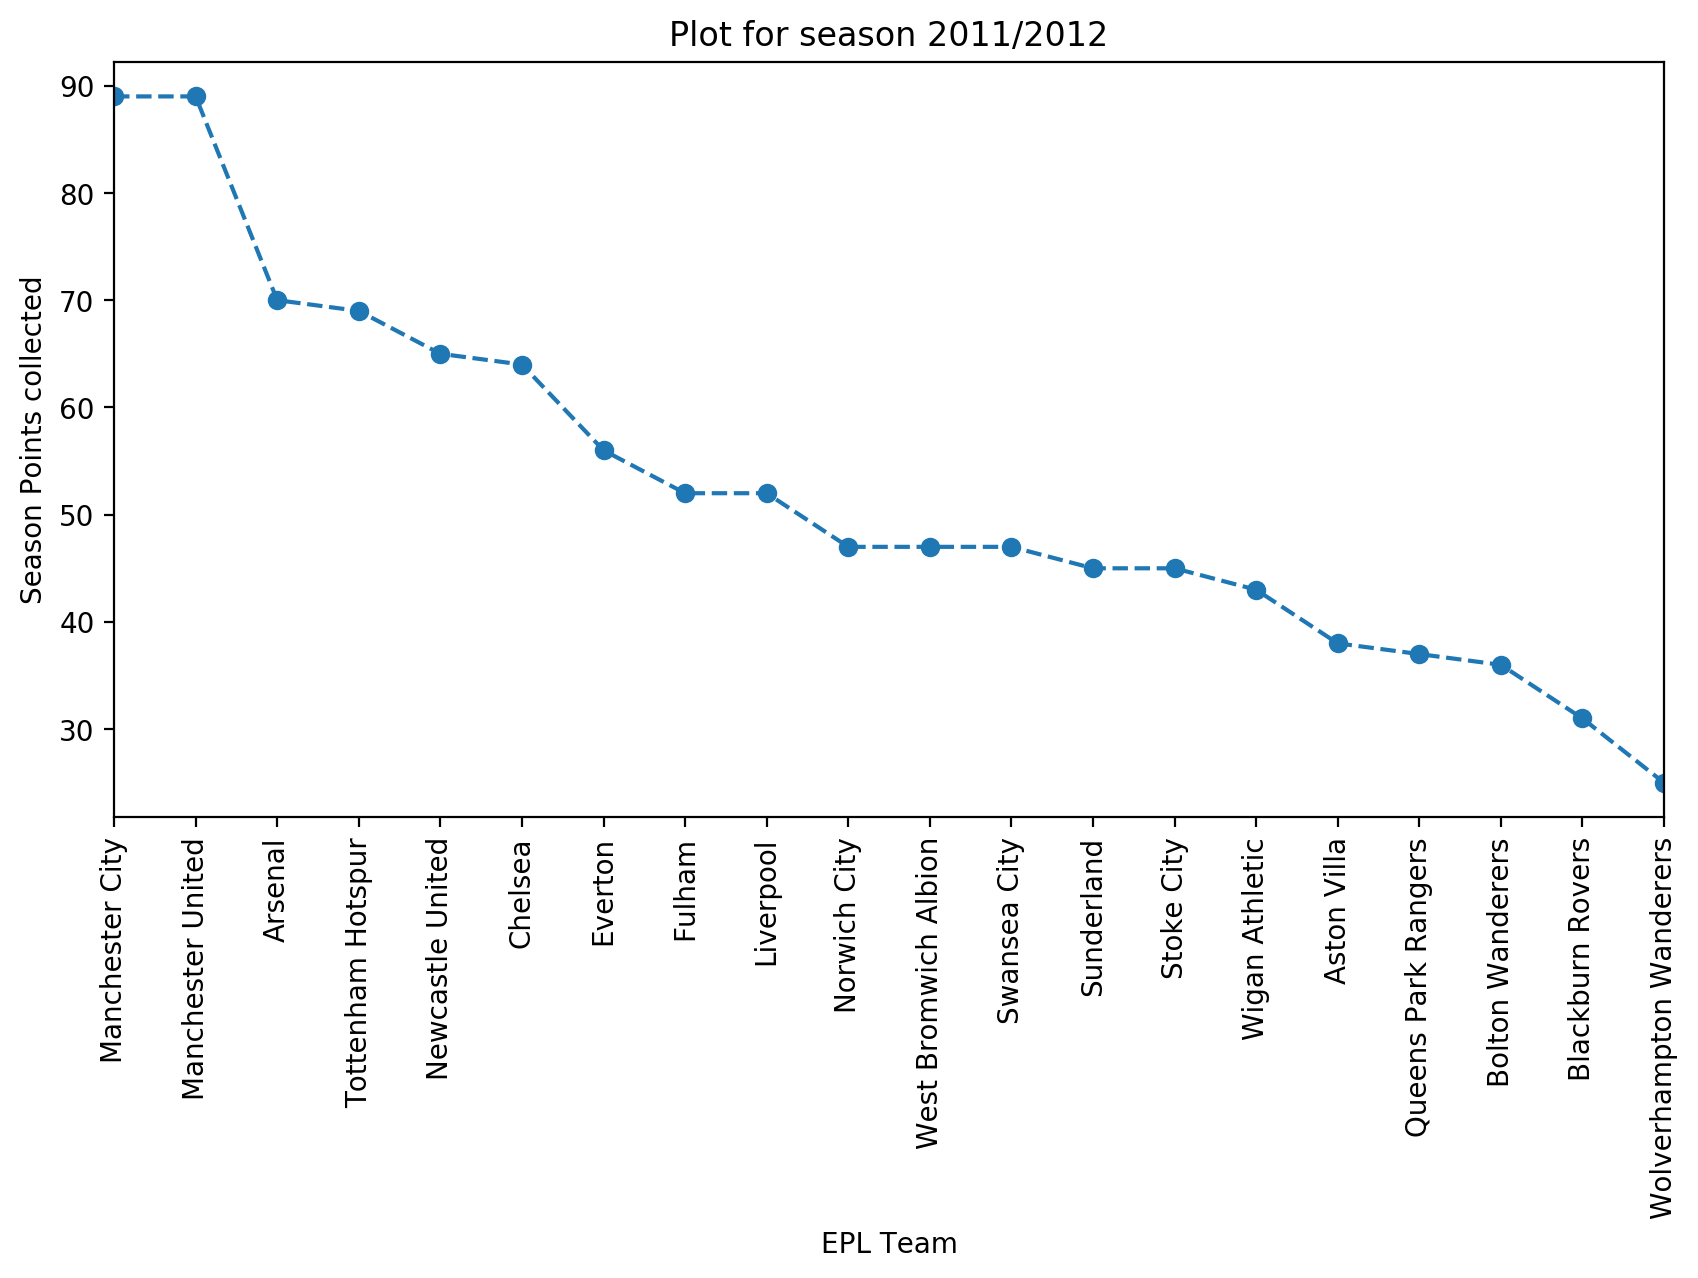

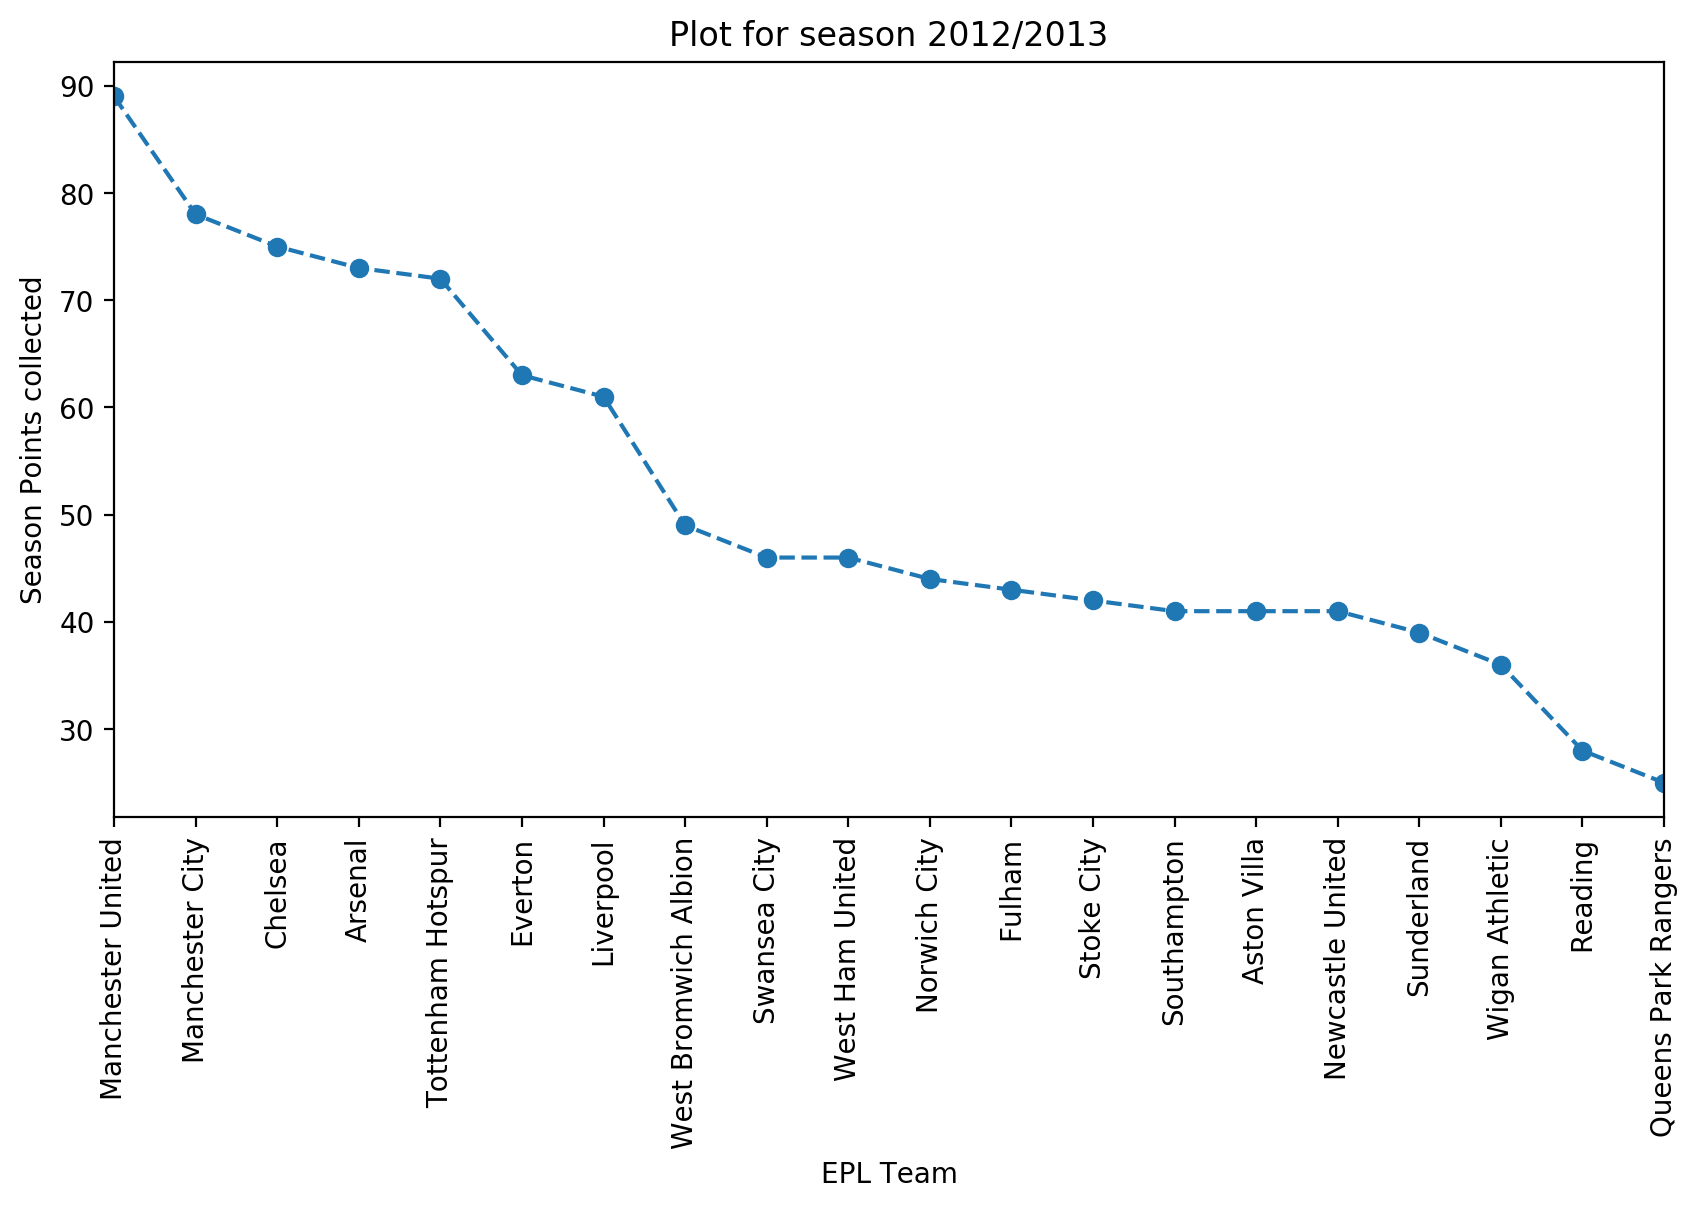

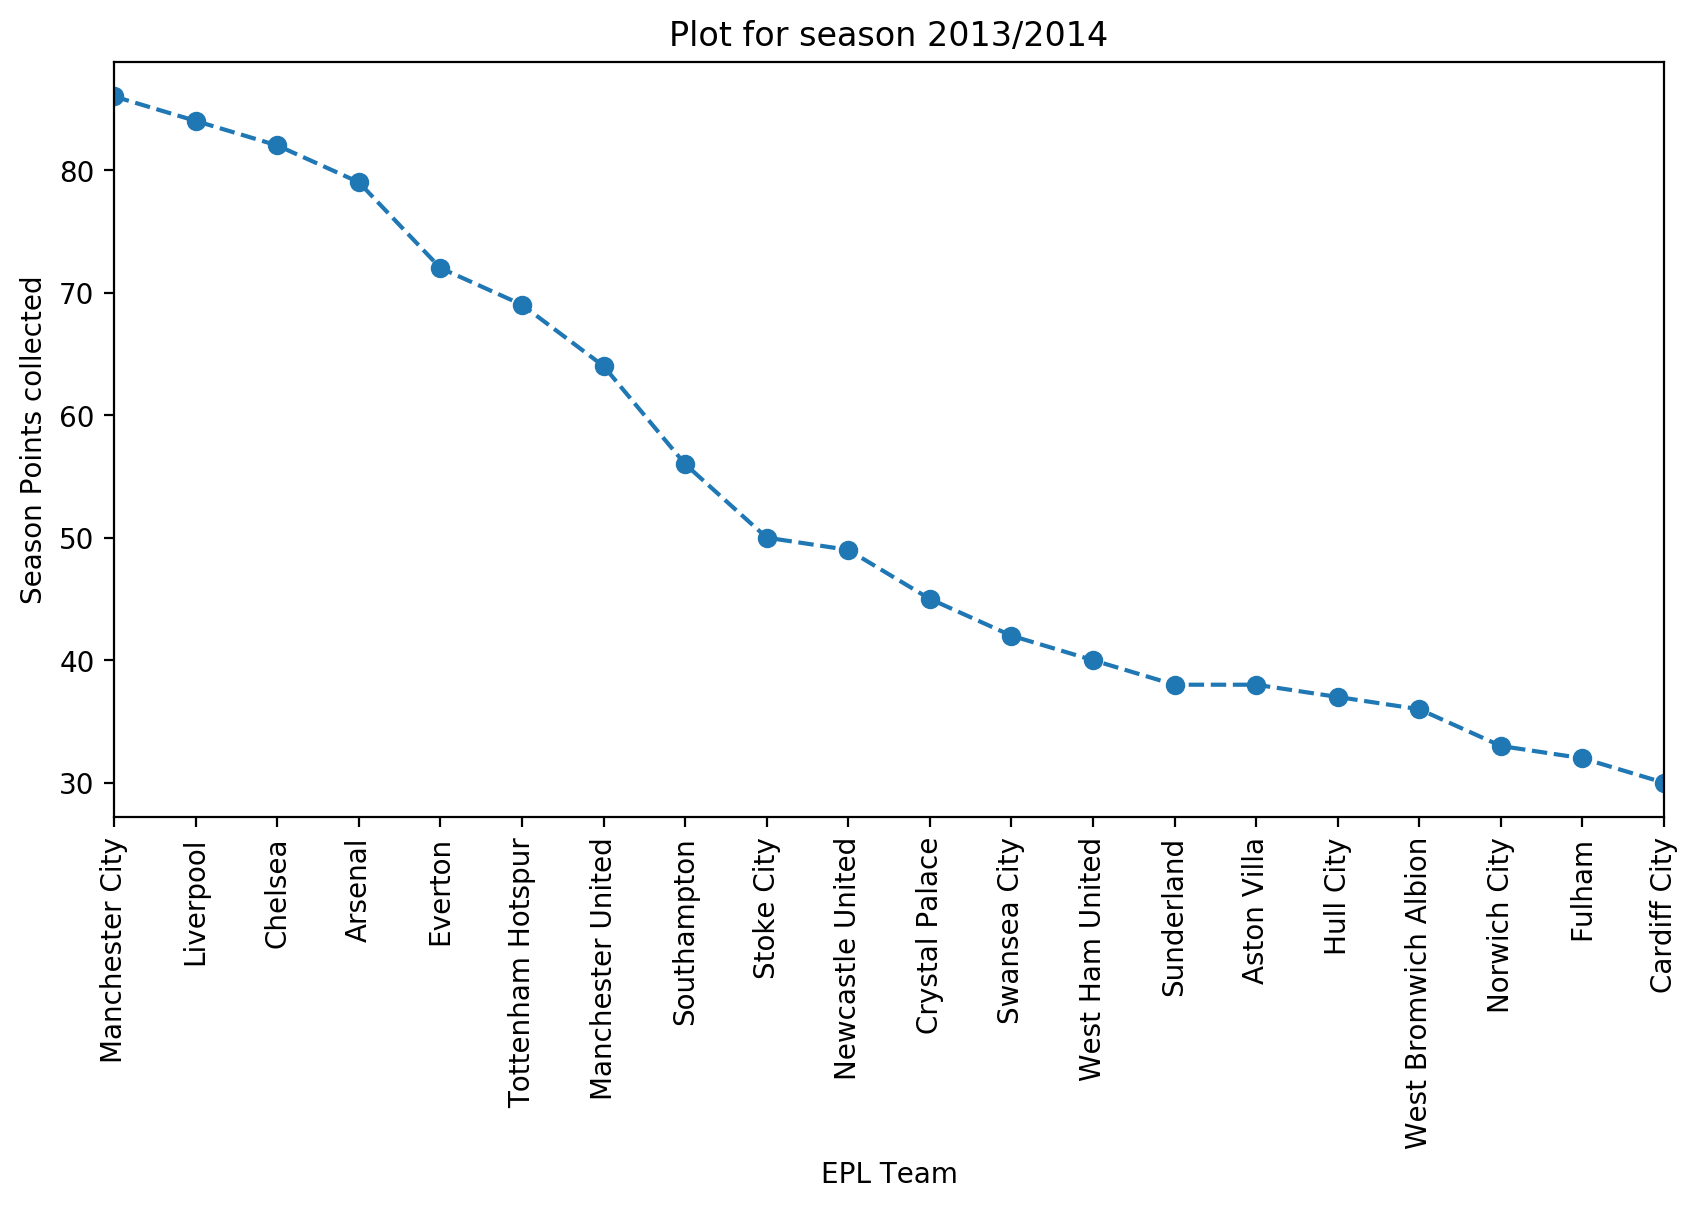

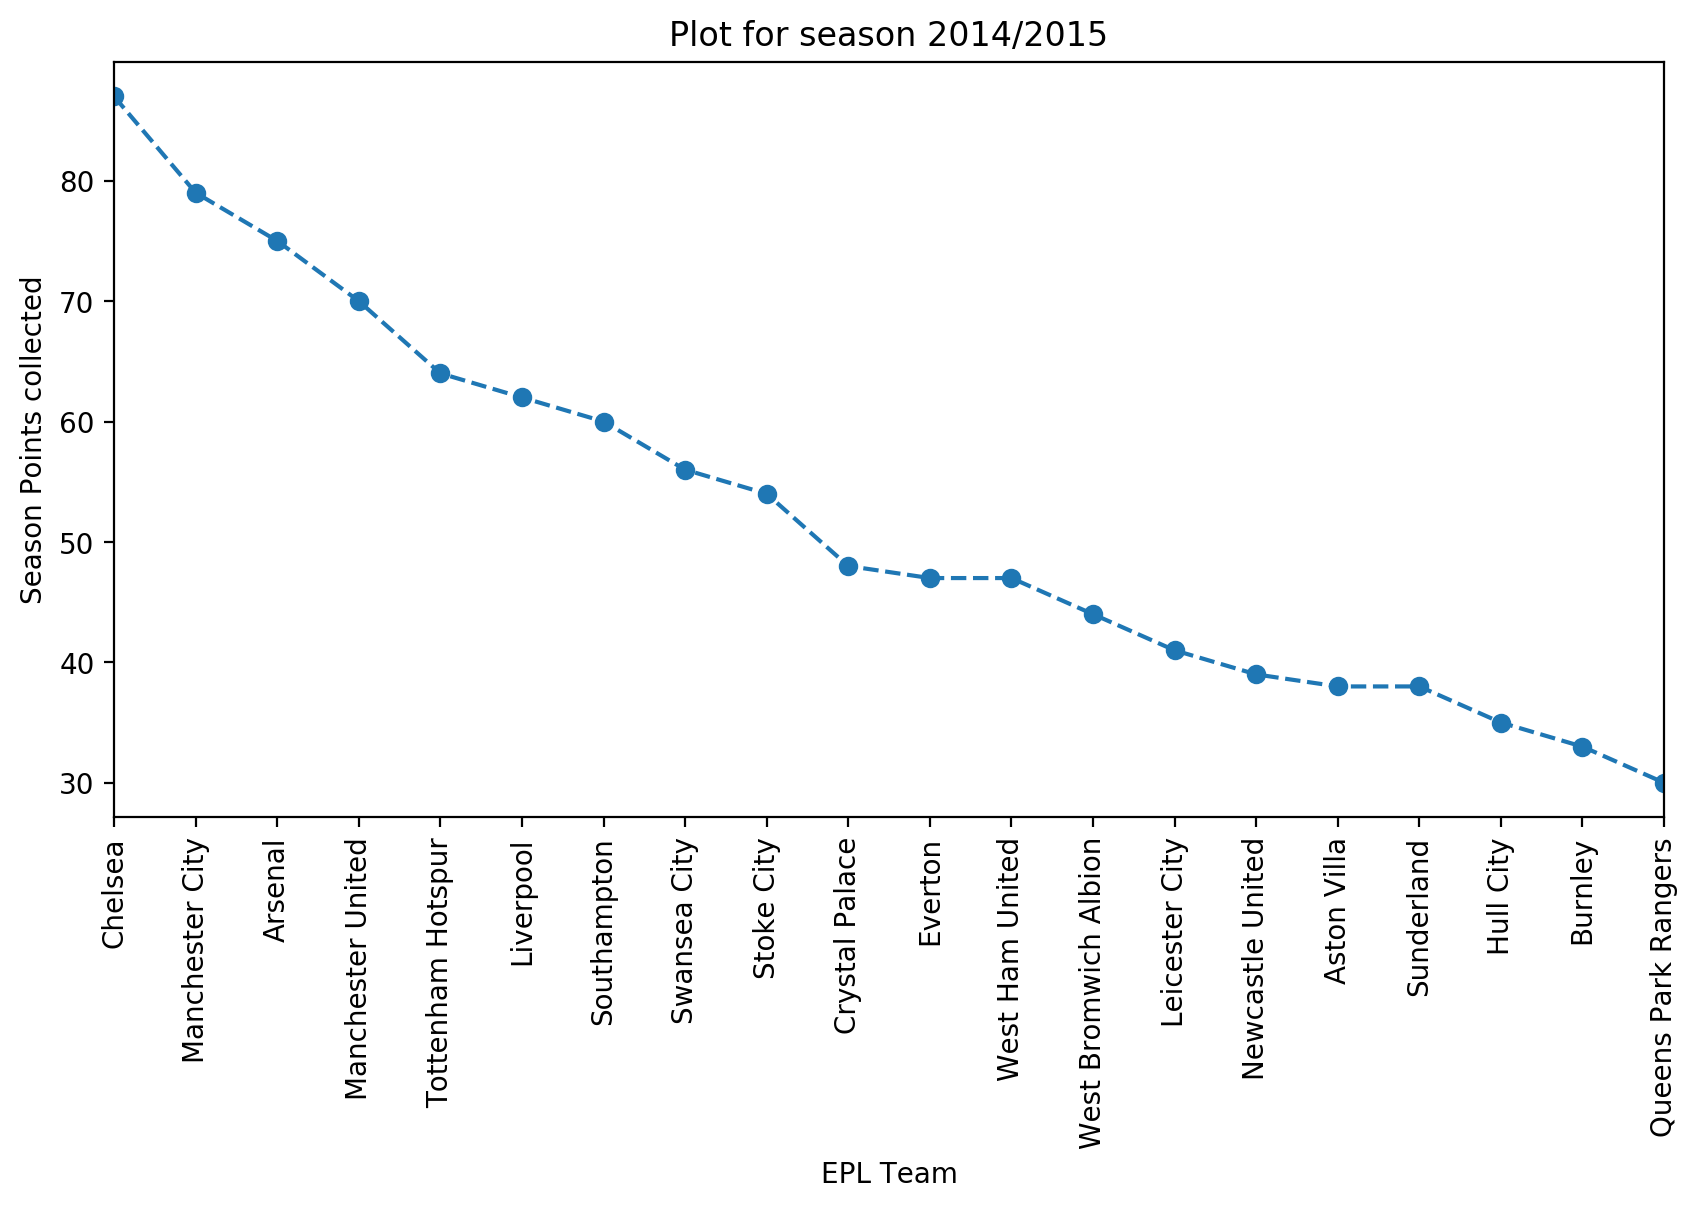

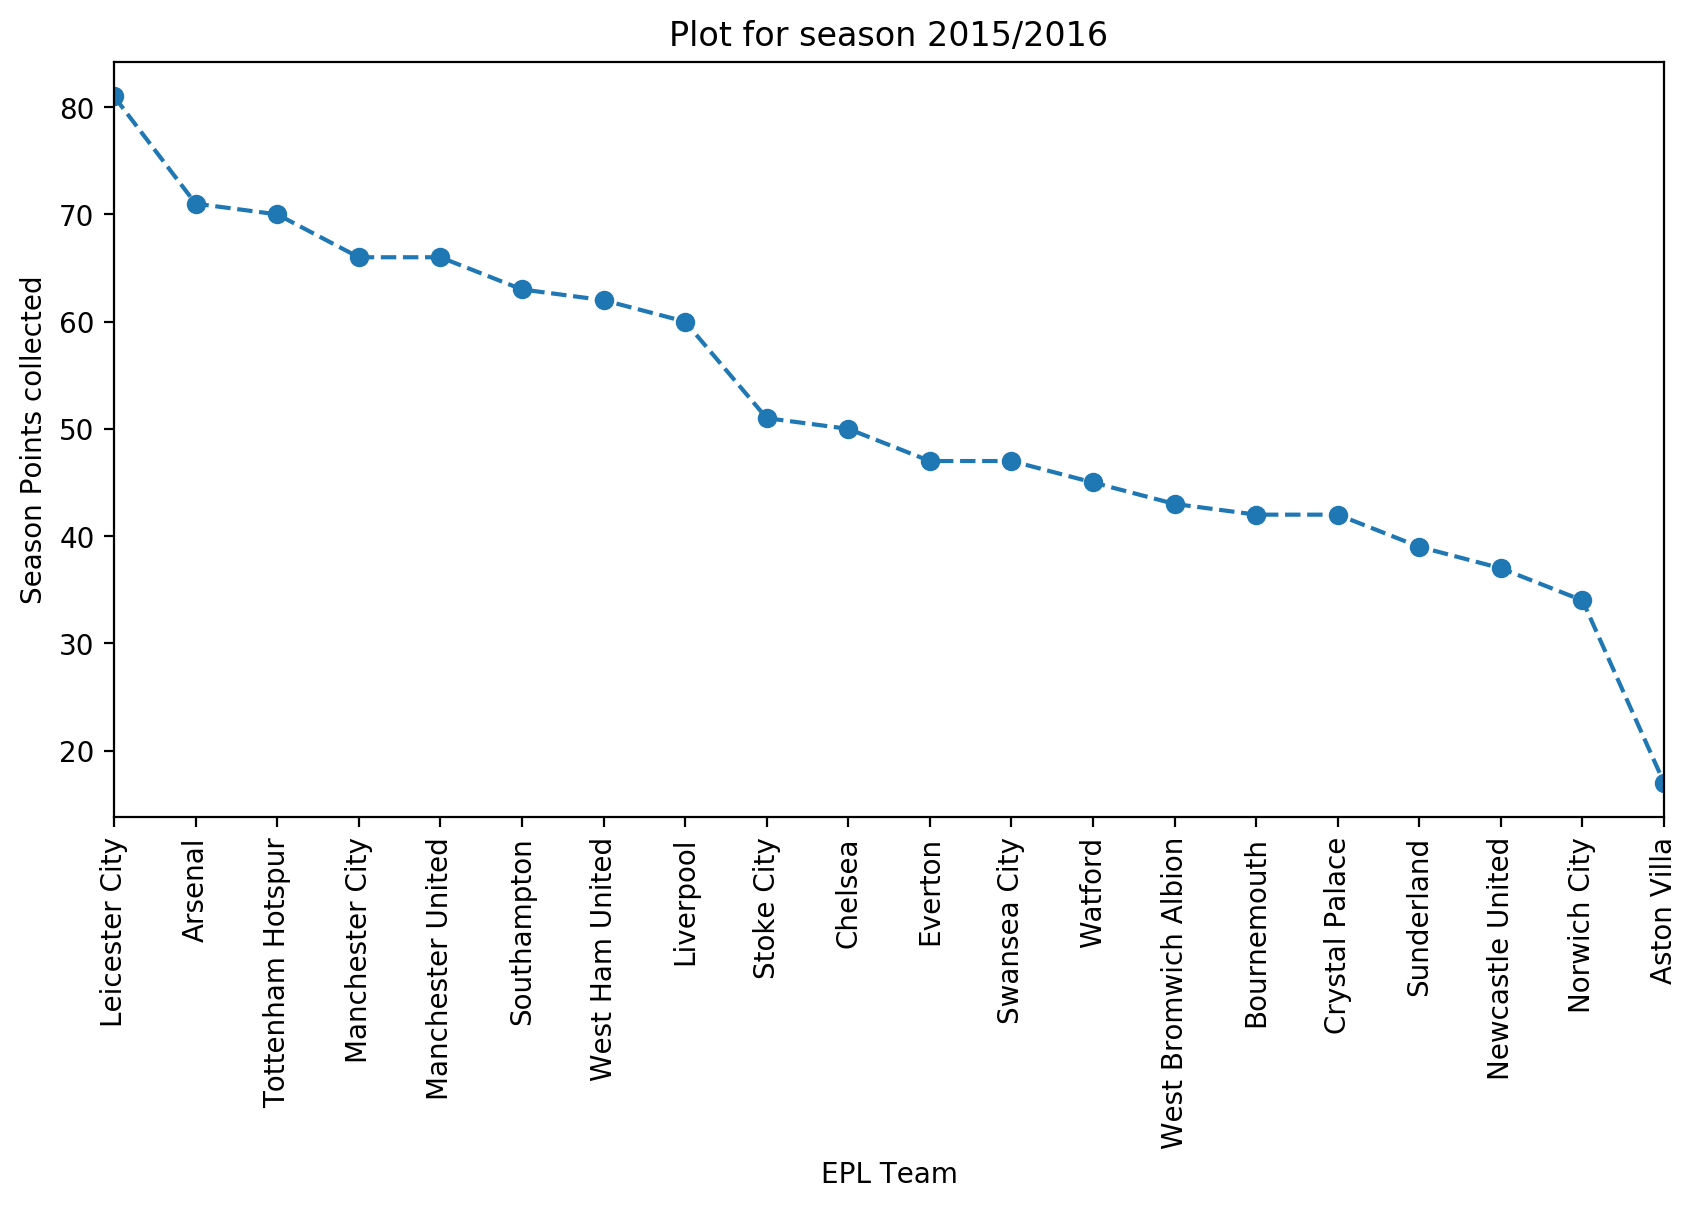

In [35]:
# Scenario 2: Work on all the seasons, but for a particular league, say EPL
num_of_seasons = len(keys)
for ix in keys:
    #print('ix ', ix)
    data_for_analysis_by_season = filter_by_league_n_season(match_csv, league_id, ix)
    #print(data_for_analysis_by_season.head(2))
    team_scores = process_winner(data_for_analysis_by_season)
    
    print(team_scores.head(1))
  
    print("The top team is {} for season {}"
          .format(team_csv[team_csv['team_api_id'] == team_scores.first_valid_index()]['team_long_name'].to_string(index=False), ix))

    new_x = convert_id_2_Name(team_scores.index.tolist(), 'team')
    

    plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(new_x, team_scores['Score'],marker='o', linestyle='dashed')
    plt.title('Plot for season {}'.format(ix))
    plt.xlabel('EPL Team')
    plt.xlim((0, 19))
    plt.xticks(new_x, rotation=90)
    plt.ylabel('Season Points collected')
    #plt.ylim( (0, 100) )
    #plt.yticks(np.linspace(10, 100, 10, endpoint=True))
plt.show()

In [36]:
# Number of goals scored by user across different season.

The player who has the hit maximum goals for 2008/2009 season is Nicolas Anelka. The number of goals are 19


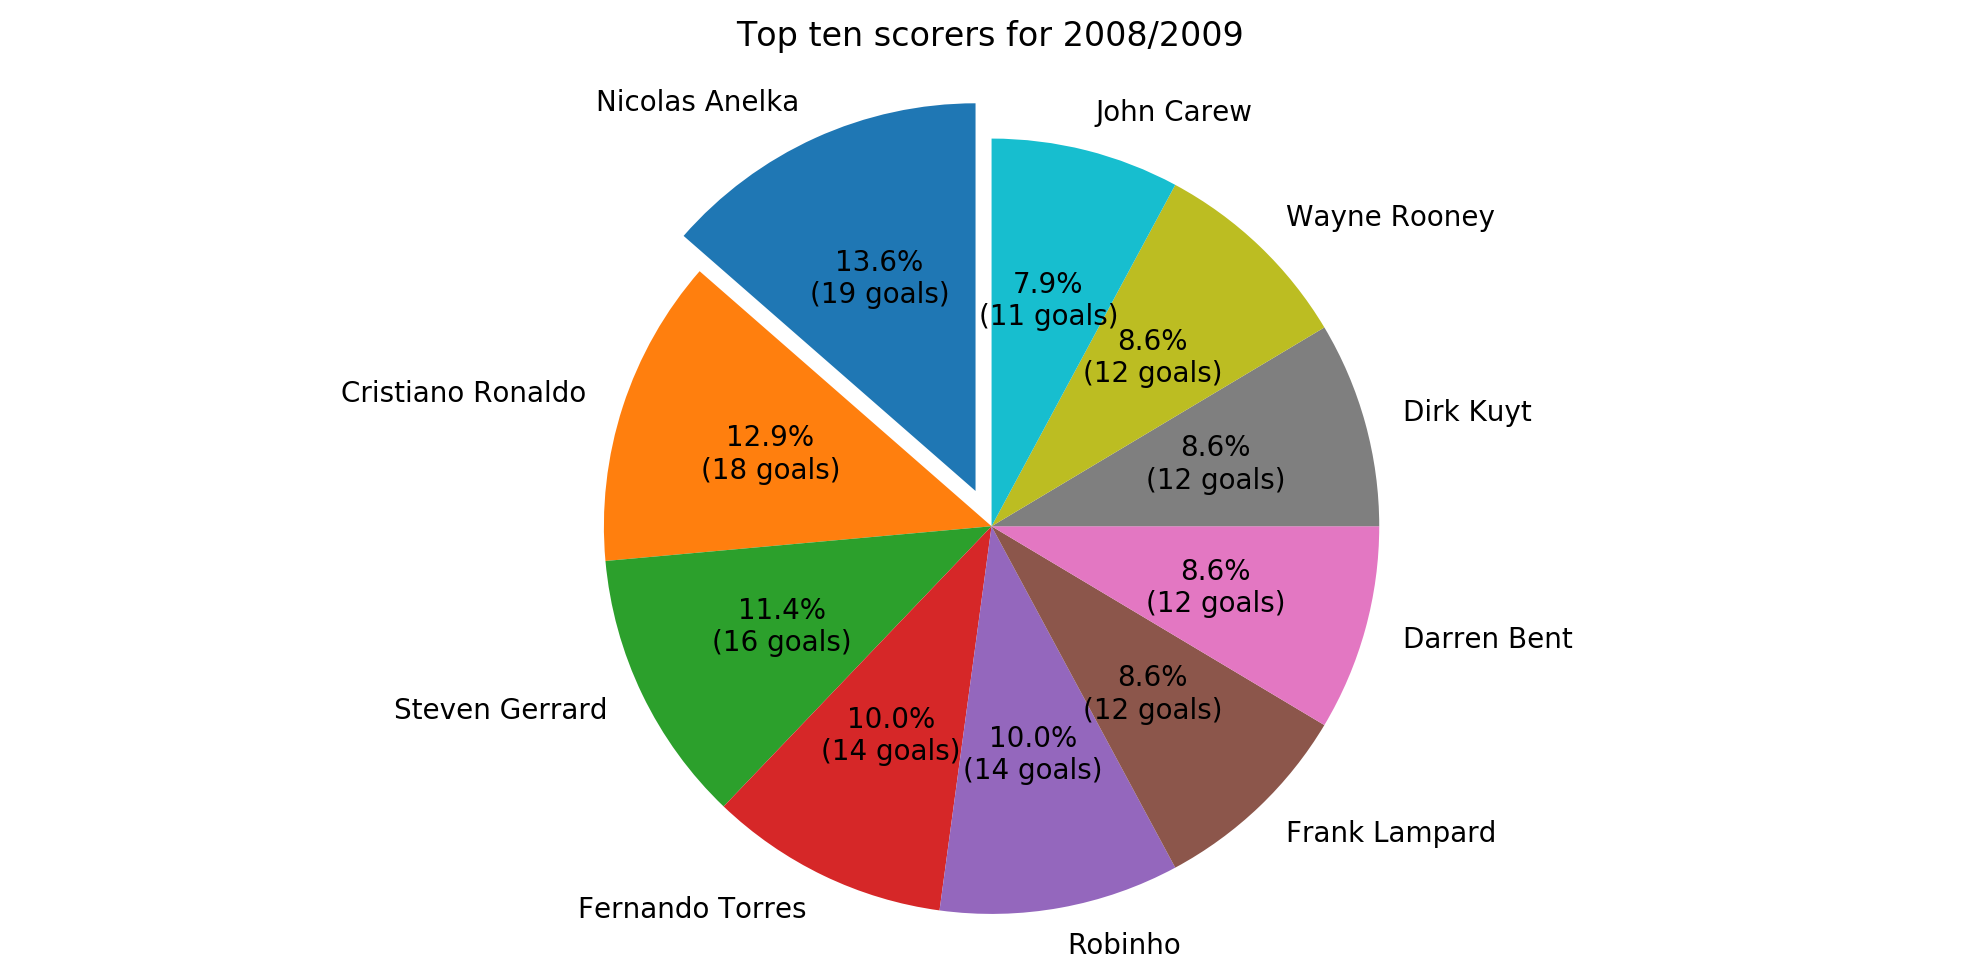

The player who has the hit maximum goals for 2009/2010 season is Didier Drogba. The number of goals are 29


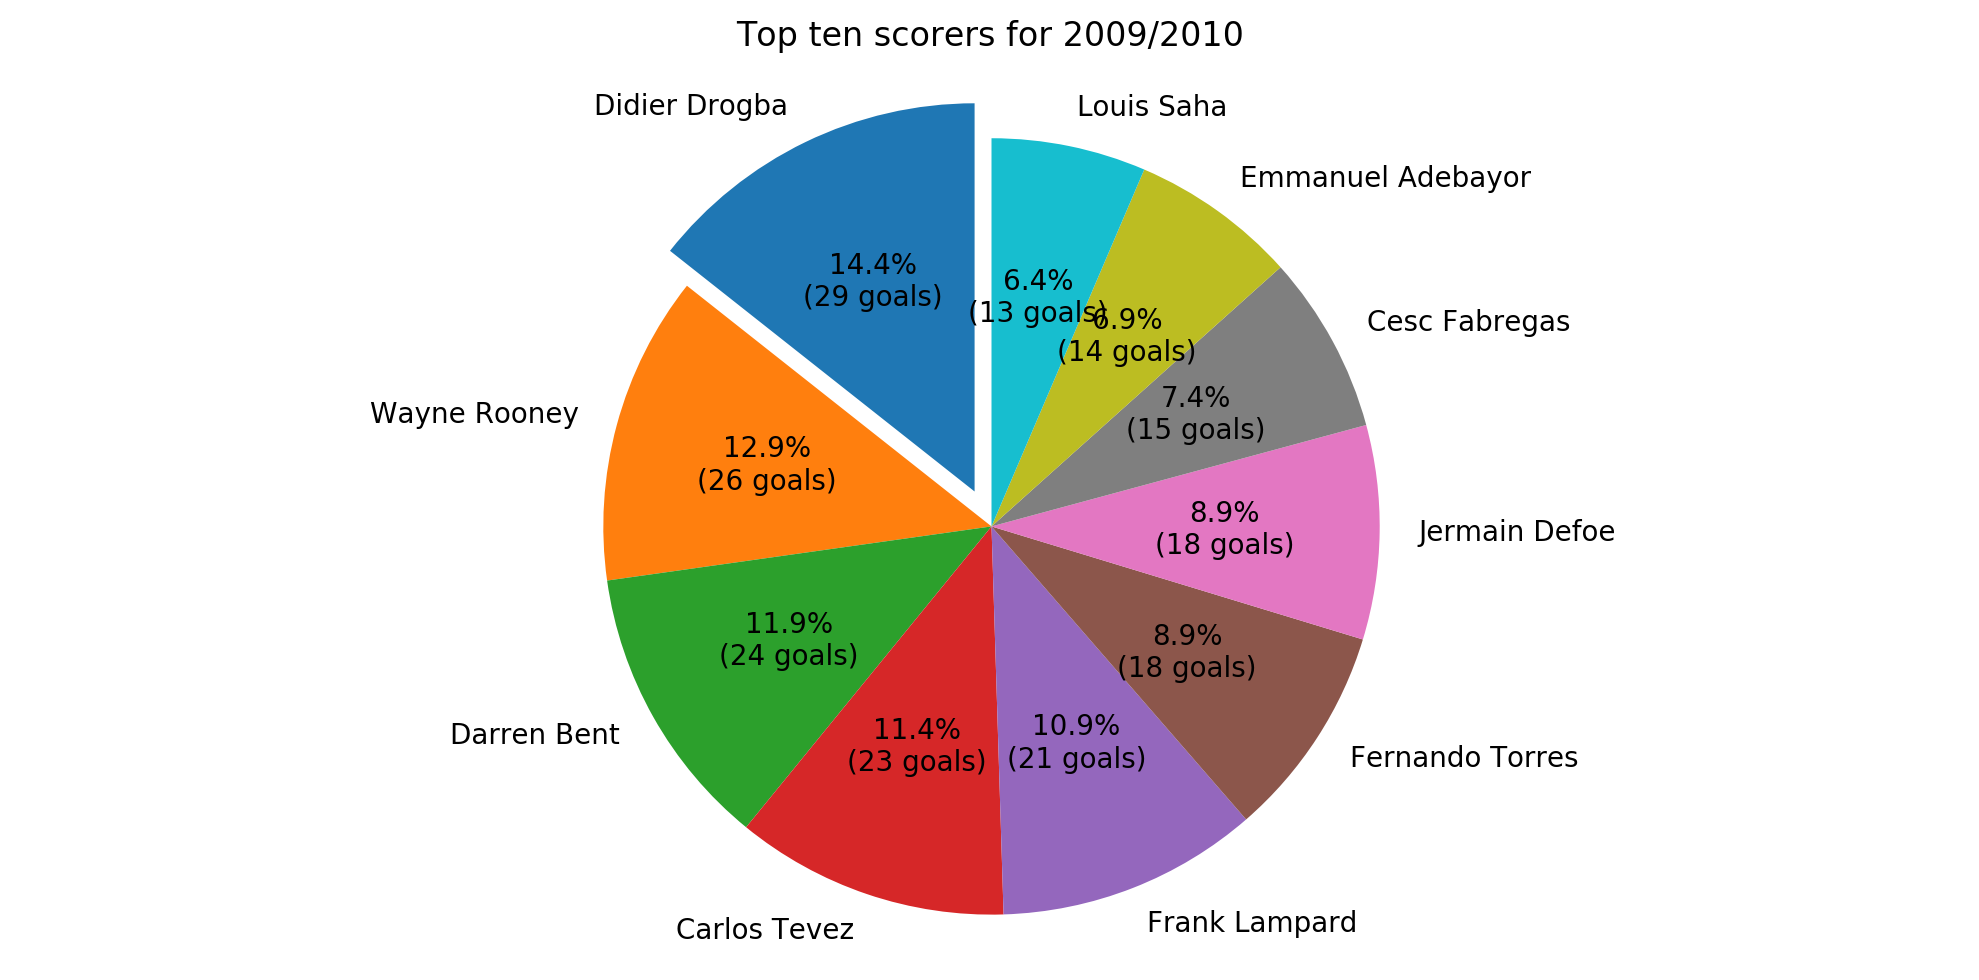

The player who has the hit maximum goals for 2010/2011 season is Dimitar Berbatov. The number of goals are 20


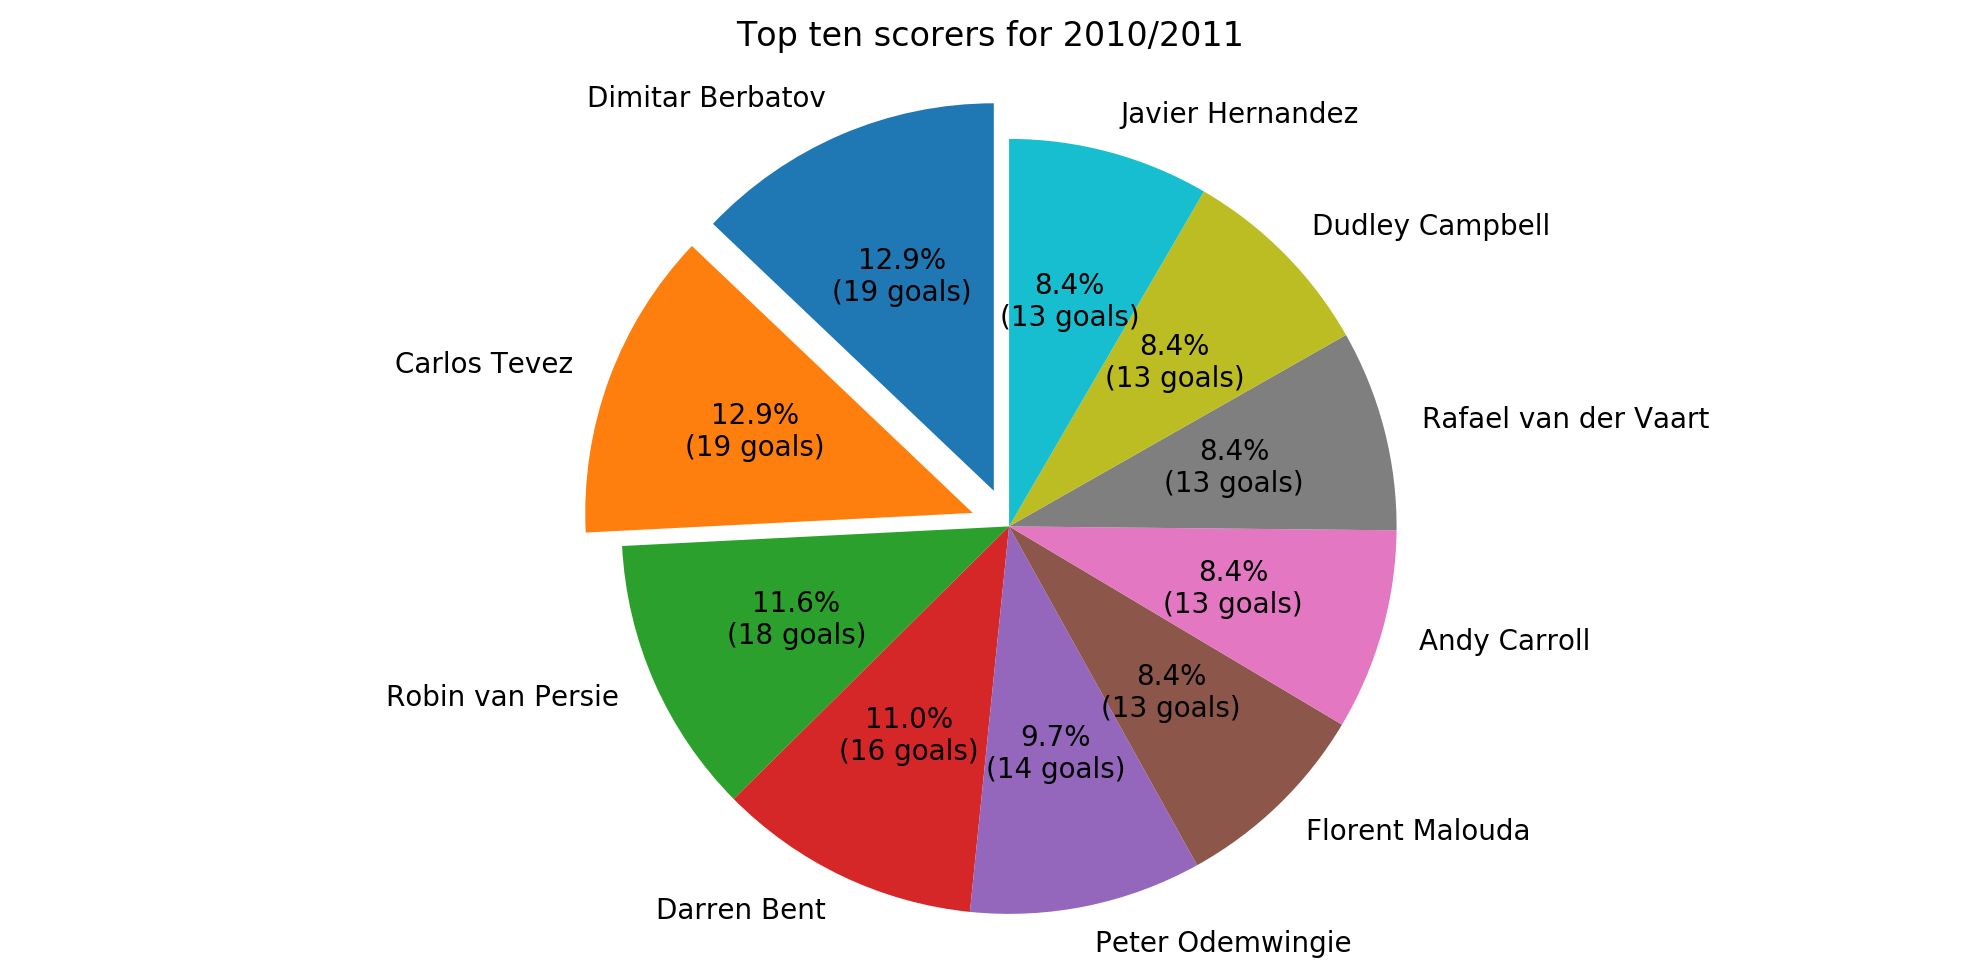

The player who has the hit maximum goals for 2011/2012 season is Robin van Persie. The number of goals are 30


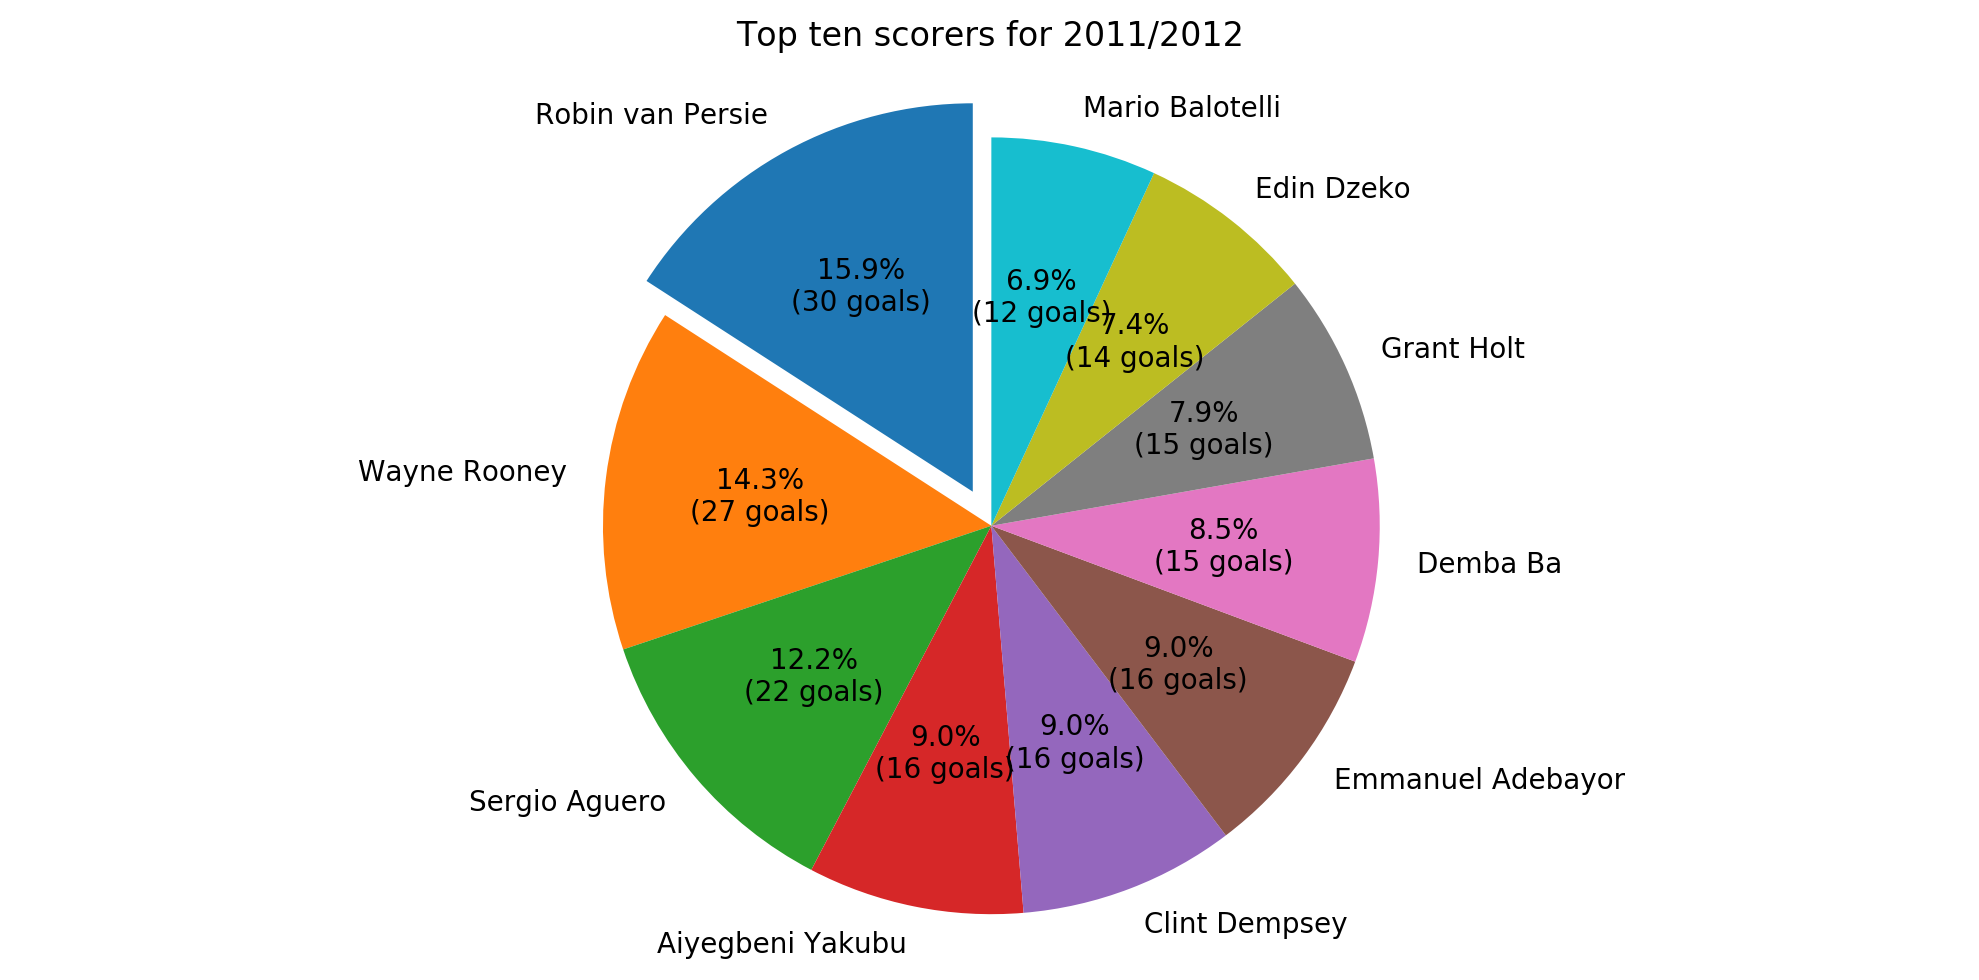

The player who has the hit maximum goals for 2012/2013 season is Robin van Persie. The number of goals are 26


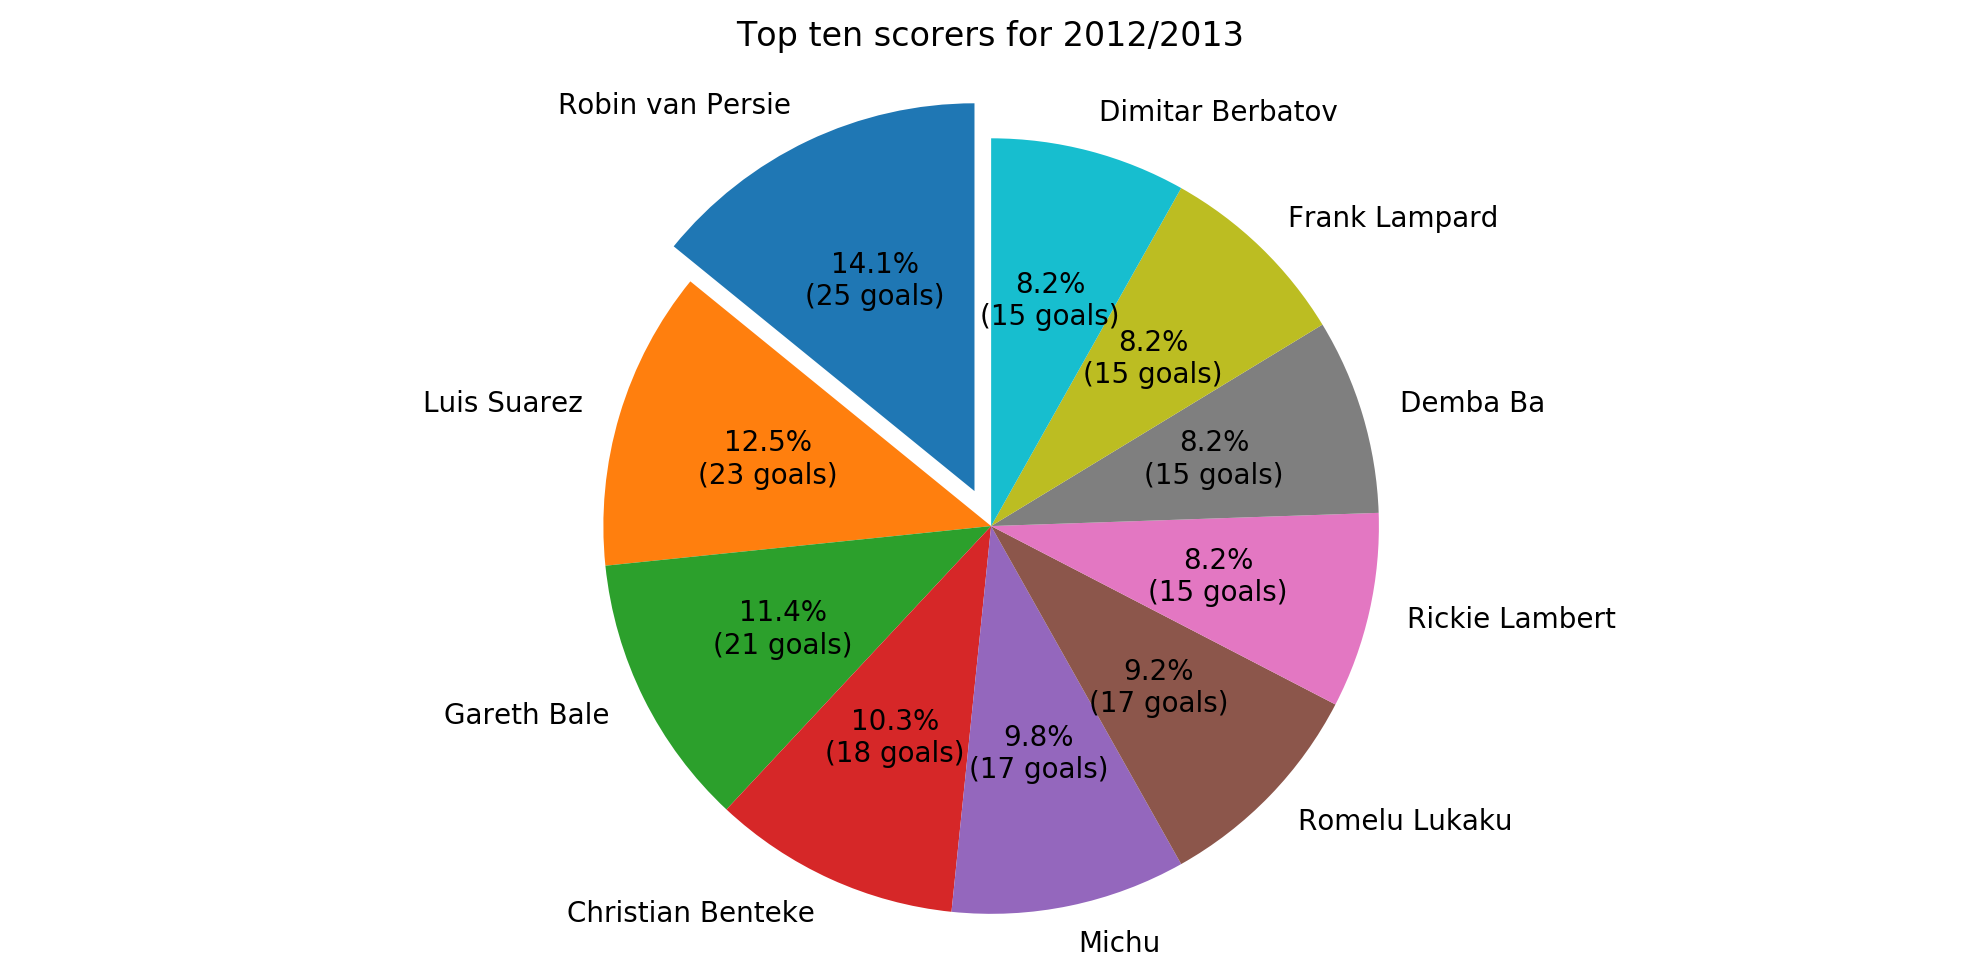

The player who has the hit maximum goals for 2013/2014 season is Luis Suarez. The number of goals are 31


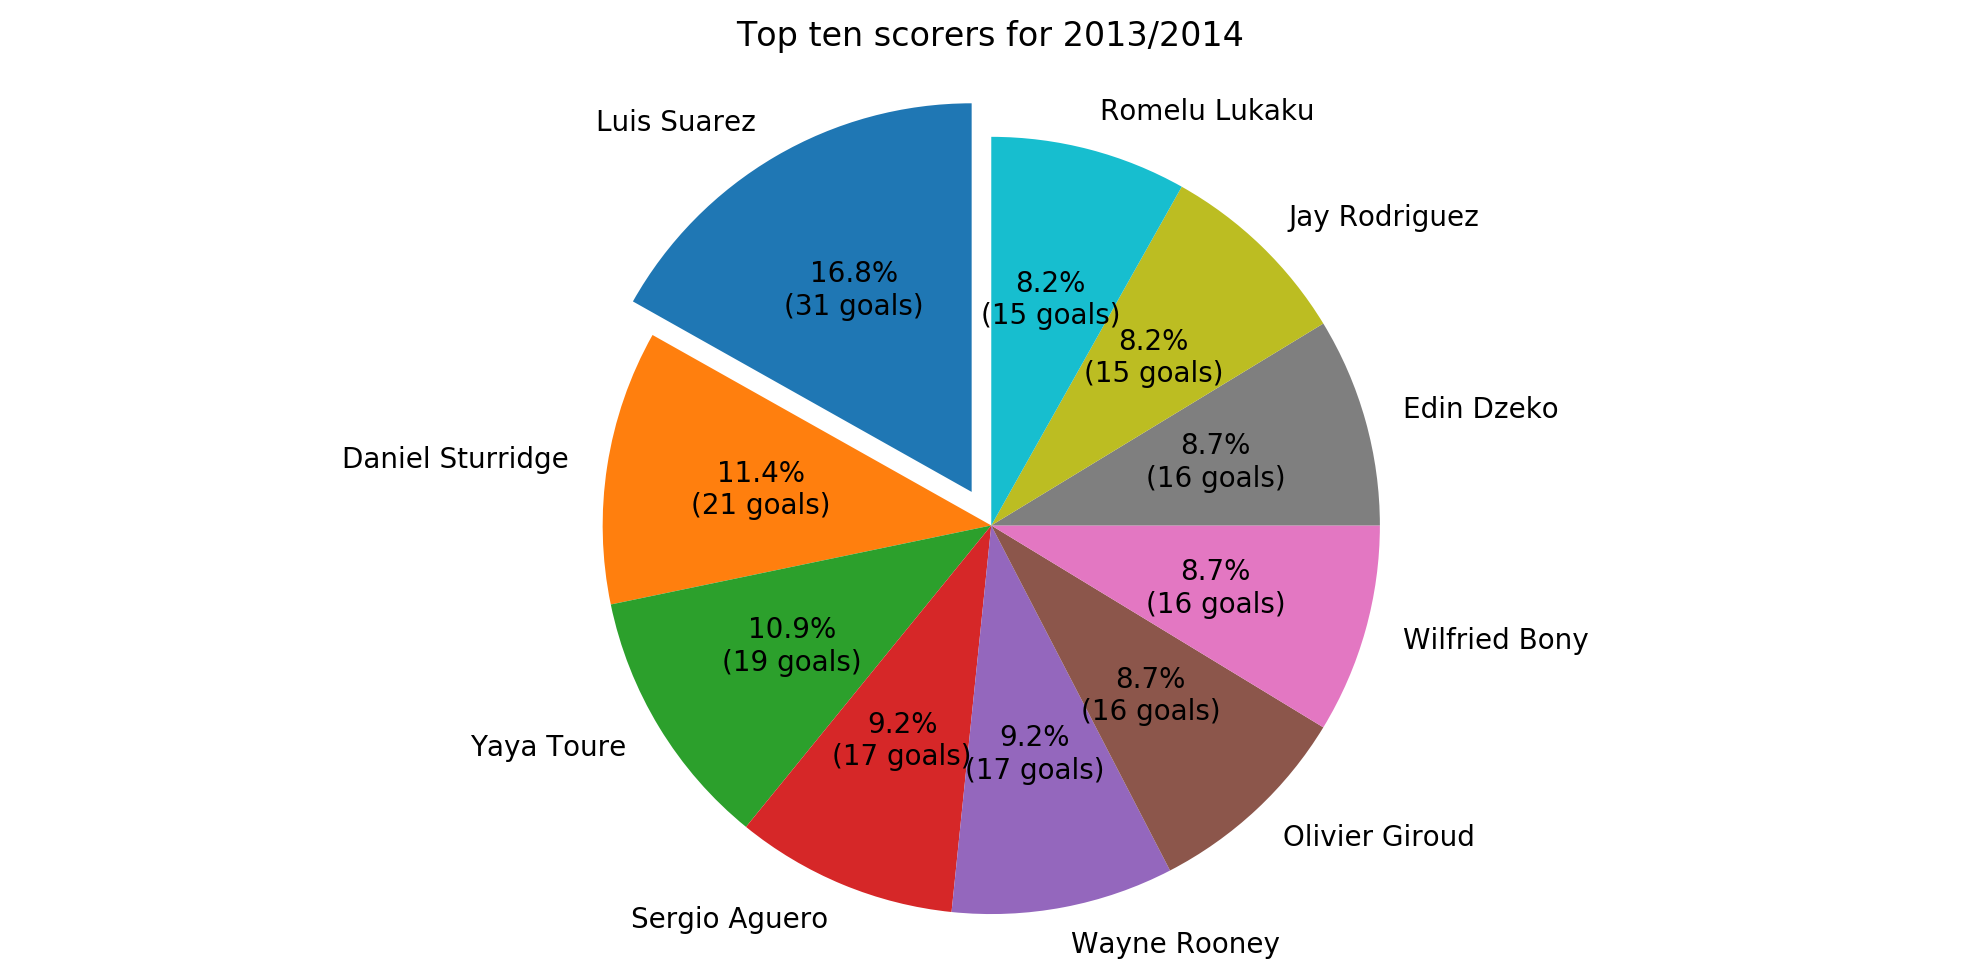

The player who has the hit maximum goals for 2014/2015 season is Sergio Aguero. The number of goals are 26


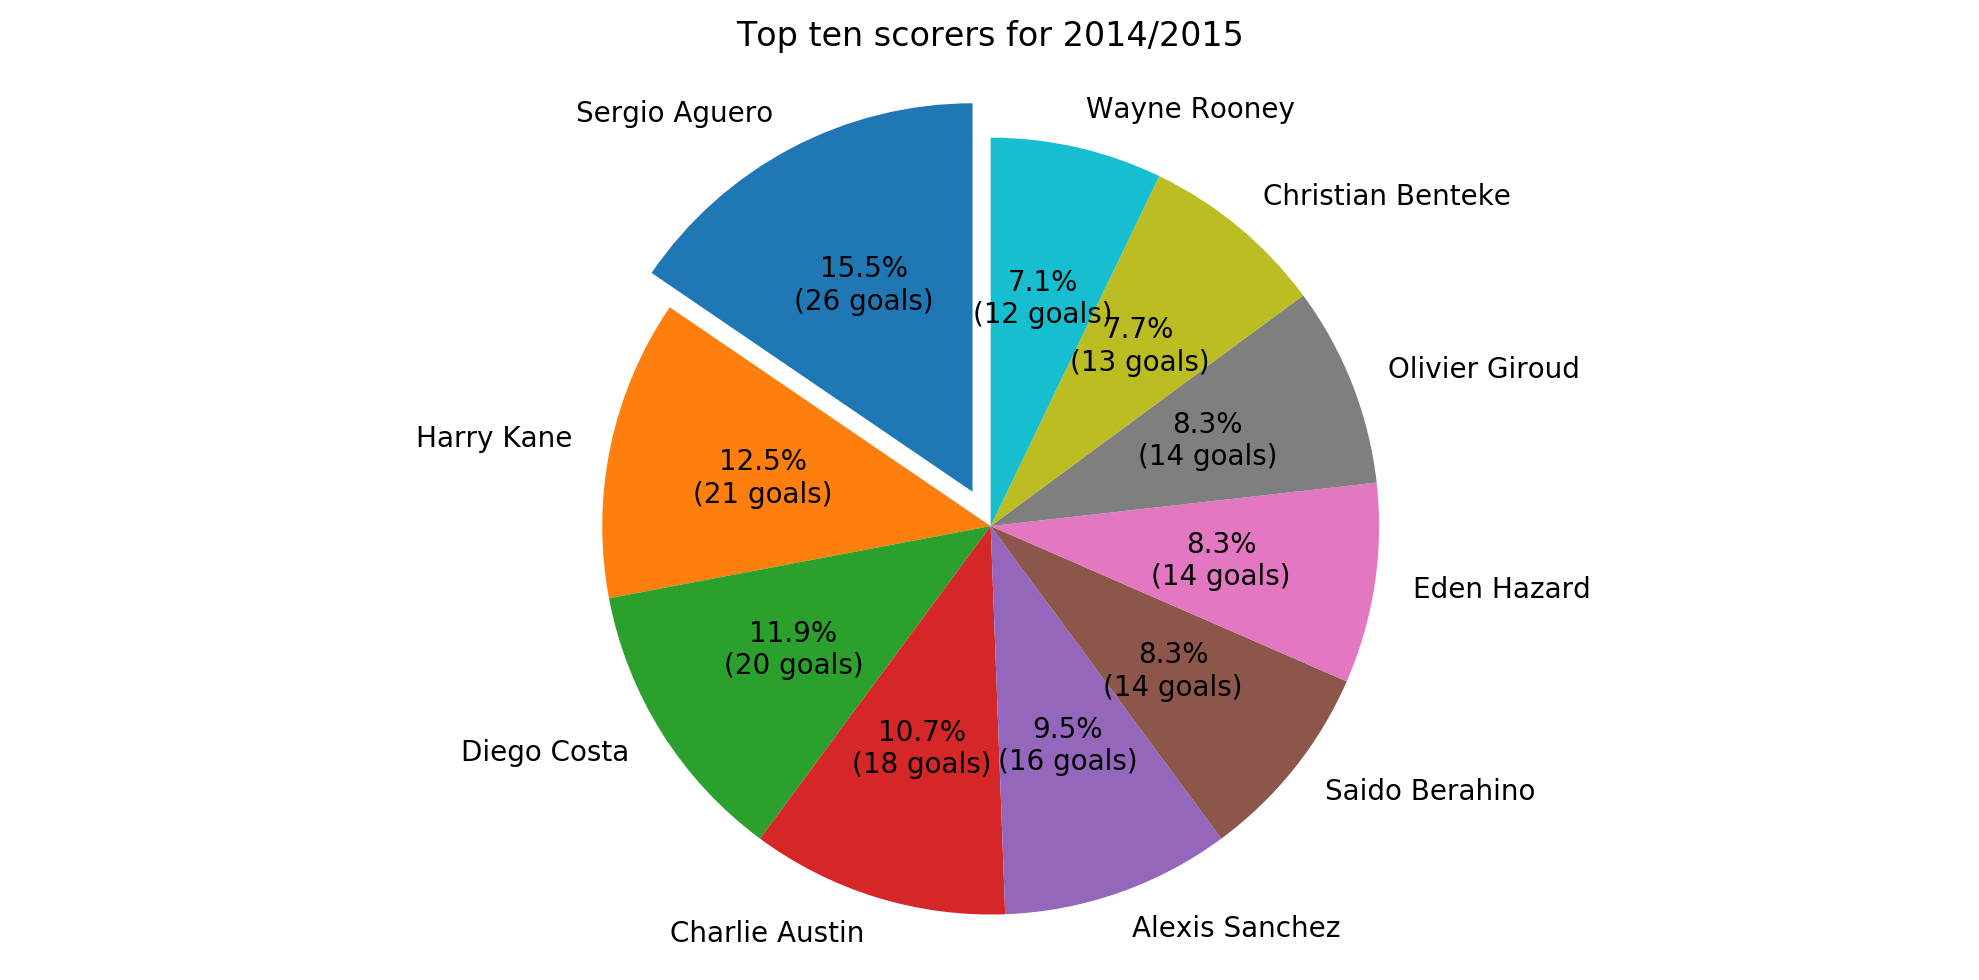

The player who has the hit maximum goals for 2015/2016 season is Harry Kane. The number of goals are 25


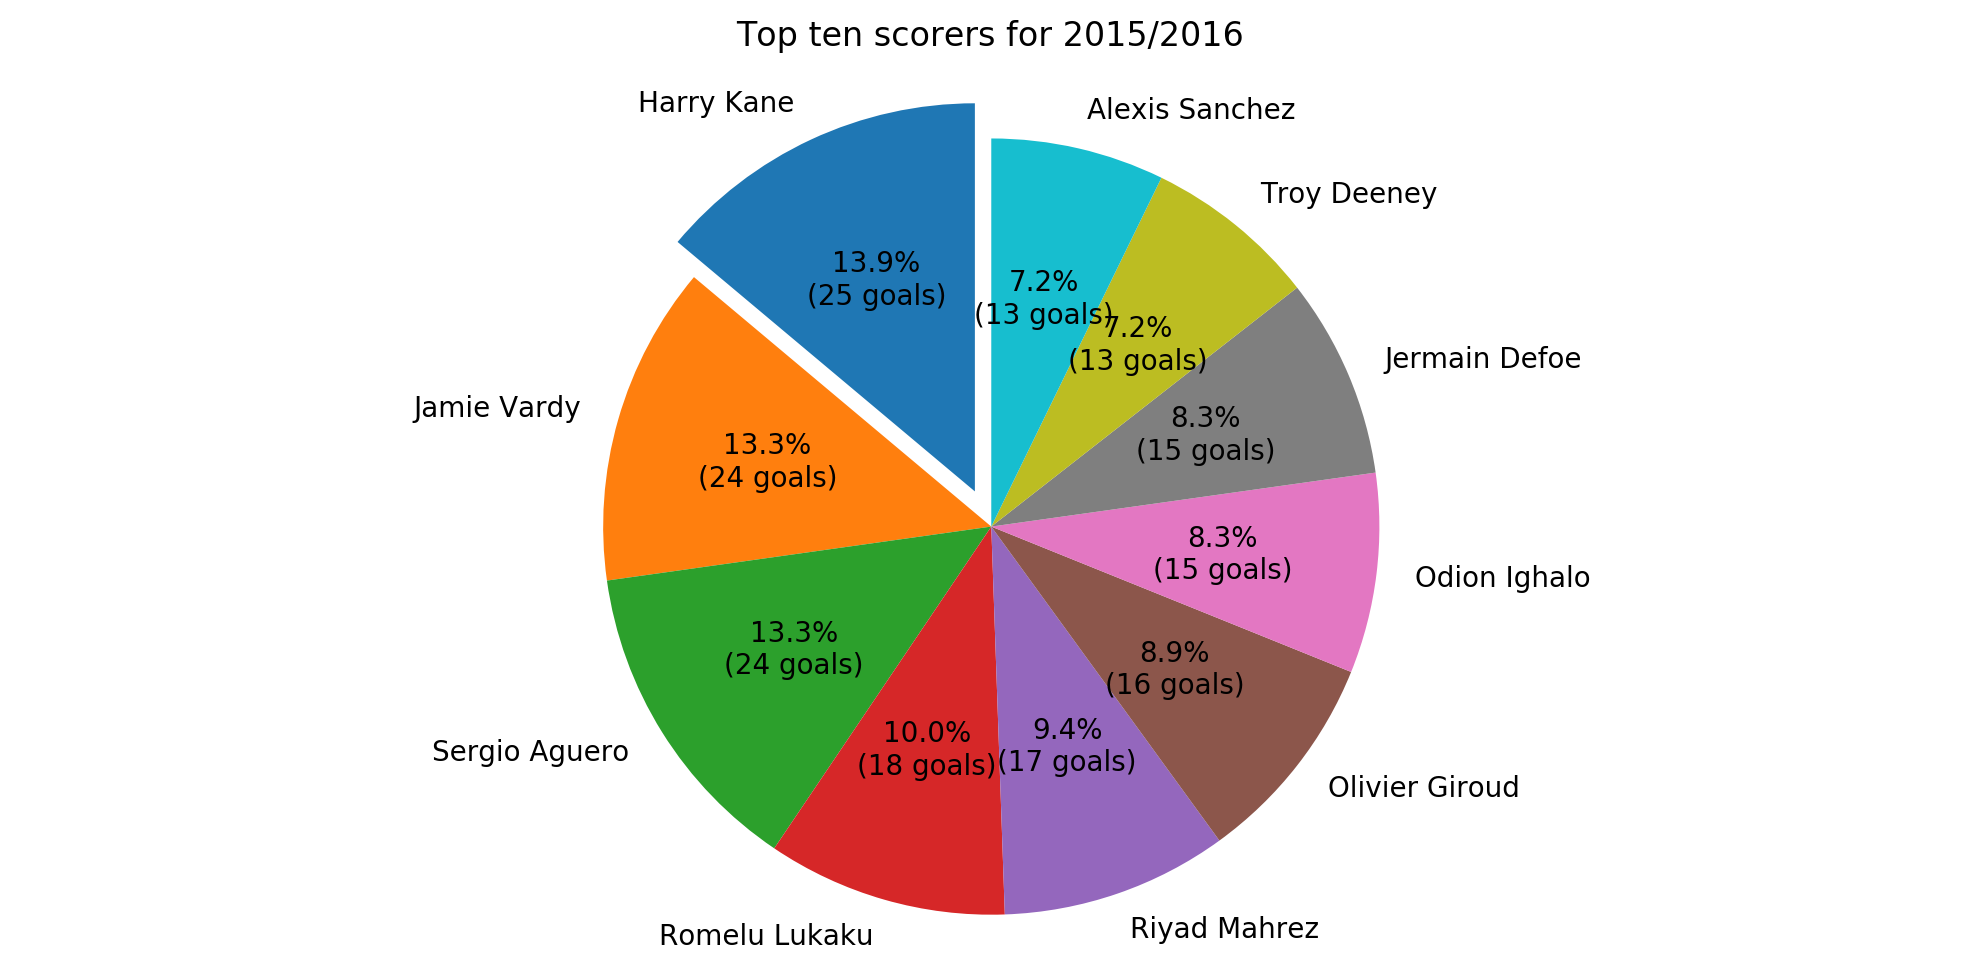

In [37]:
import operator


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} goals)".format(pct, absolute)

number_one_player = []
player_overall_rating = []

for ix in keys:
    #print('ix ', ix)
    data_for_analysis_by_scorer = filter_by_league_n_season(match_csv, league_id, ix)
    top_scorer_dict = calculate_top_scorer(data_for_analysis_by_scorer)
    top_scorer = max(top_scorer_dict, key=top_scorer_dict.get)
    
    record = player_csv[player_csv['player_api_id'] == int(top_scorer)]
    print('The player who has the hit maximum goals for {} season is {}. The number of goals are {}'
                          .format(ix, record['player_name'].to_string(index=False), top_scorer_dict[top_scorer]))
    
    #lists = sorted(top_scorer_dict.items()) # sorted by key, return a list of tuples
    lists = sorted(top_scorer_dict.items(), key=operator.itemgetter(1), reverse=True)
    #print(lists)
    
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    
    number_one_player.append(x[0])
    
    x_limit = x[:10]
    y_limit = y[:10]
    #new_x = [player_csv[player_csv['player_api_id'] == int(elem)]['player_name'].to_string(index=False) for elem in x_limit]
    new_x = convert_id_2_Name(x_limit, 'player')
    #print(new_x)
    plt.figure(figsize=(10, 5), dpi=200)
    #plt.bar(new_x, y_limit)
    labels = new_x
    sizes = y_limit
    #print(y_limit)
    explode = [0.1 if x == max(y_limit) else 0 for x in y_limit]
    #print(explode)
    plt.pie(sizes, explode, labels=labels, autopct=lambda pct: func(pct, sizes), shadow=False, startangle=90)
    
    plt.title('Top ten scorers for {}'.format(ix))
    plt.axis('equal')  
    plt.tight_layout()

    plt.show()   

In [38]:
mode_count = max(number_one_player, key=number_one_player.count)
# High Rater Player based since he was a max scorer twice.. 
player_csv[player_csv['player_api_id'] == int(mode_count)]['player_name'].to_string(index=False)

'Robin van Persie'

In [39]:
number_one_player[-1]
# Player with top scorer for 2015/2016 year.
player_csv[player_csv['player_api_id'] == int(number_one_player[-1])]['player_name'].to_string(index=False)

'Harry Kane'

In [40]:
number_one_player

['37804', '30822', '27430', '30843', '30843', '40636', '37412', '194165']

In [42]:
# Lets prove that the above footballer is the really is Good Player by looking at his overall ratings...
new_x = convert_id_2_Name(number_one_player, 'player')
player_overall_rating = {}
#print(keys)
for ix in keys:
    rating_for_year = []
    for player_id in number_one_player:  
        #print(player_id)
        year_1, year_2 = ix.split("/")
        #print(year_1, year_2)
        int_val = int(float(get_player_overall_attribute(player_attrib_csv, player_id, year_1, year_2)))
        rating_for_year.append(int_val)
        #print(rating_for_year)
        player_overall_rating[year_2] = rating_for_year    
df = pd.DataFrame.from_dict(player_overall_rating, orient='index', columns = new_x )
#print(df)
#print(df.T.groupby(level=0).first())
df = df.T.groupby(level=0).first()
df.T.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 columns):
player_api_id     183977 non-null int64
player_name       183977 non-null object
overall_rating    183142 non-null float64
date              183977 non-null datetime64[ns]
year              183977 non-null int64
month             183977 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 8.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 columns):
player_api_id     183977 non-null int64
player_name       183977 non-null object
overall_rating    183142 non-null float64
date              183977 non-null datetime64[ns]
year              183977 non-null int64
month             183977 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 8.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 colu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 columns):
player_api_id     183977 non-null int64
player_name       183977 non-null object
overall_rating    183142 non-null float64
date              183977 non-null datetime64[ns]
year              183977 non-null int64
month             183977 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 8.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 columns):
player_api_id     183977 non-null int64
player_name       183977 non-null object
overall_rating    183142 non-null float64
date              183977 non-null datetime64[ns]
year              183977 non-null int64
month             183977 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 8.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 colu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 columns):
player_api_id     183977 non-null int64
player_name       183977 non-null object
overall_rating    183142 non-null float64
date              183977 non-null datetime64[ns]
year              183977 non-null int64
month             183977 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 8.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 columns):
player_api_id     183977 non-null int64
player_name       183977 non-null object
overall_rating    183142 non-null float64
date              183977 non-null datetime64[ns]
year              183977 non-null int64
month             183977 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 8.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 colu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 columns):
player_api_id     183977 non-null int64
player_name       183977 non-null object
overall_rating    183142 non-null float64
date              183977 non-null datetime64[ns]
year              183977 non-null int64
month             183977 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 8.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 columns):
player_api_id     183977 non-null int64
player_name       183977 non-null object
overall_rating    183142 non-null float64
date              183977 non-null datetime64[ns]
year              183977 non-null int64
month             183977 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 8.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183977 entries, 0 to 183976
Data columns (total 6 colu

,Didier Drogba,Dimitar Berbatov,Harry Kane,Luis Suarez,Nicolas Anelka,Robin van Persie,Sergio Aguero
count,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.00000
mean,83.750000,82.125000,51.50000,84.500000,70.750000,85.875000,85.50000
std,2.052873,1.642081,32.31541,3.741657,28.689221,1.726888,1.85164
min,81.000000,80.000000,0.00000,78.000000,0.000000,83.000000,83.00000
25%,82.500000,81.000000,45.00000,82.500000,78.500000,85.000000,83.75000
50%,84.000000,82.000000,65.00000,85.000000,80.000000,85.500000,86.50000
75%,85.250000,82.500000,70.50000,87.250000,83.000000,87.250000,87.00000
max,86.000000,85.000000,78.00000,89.000000,84.000000,88.000000,87.00000


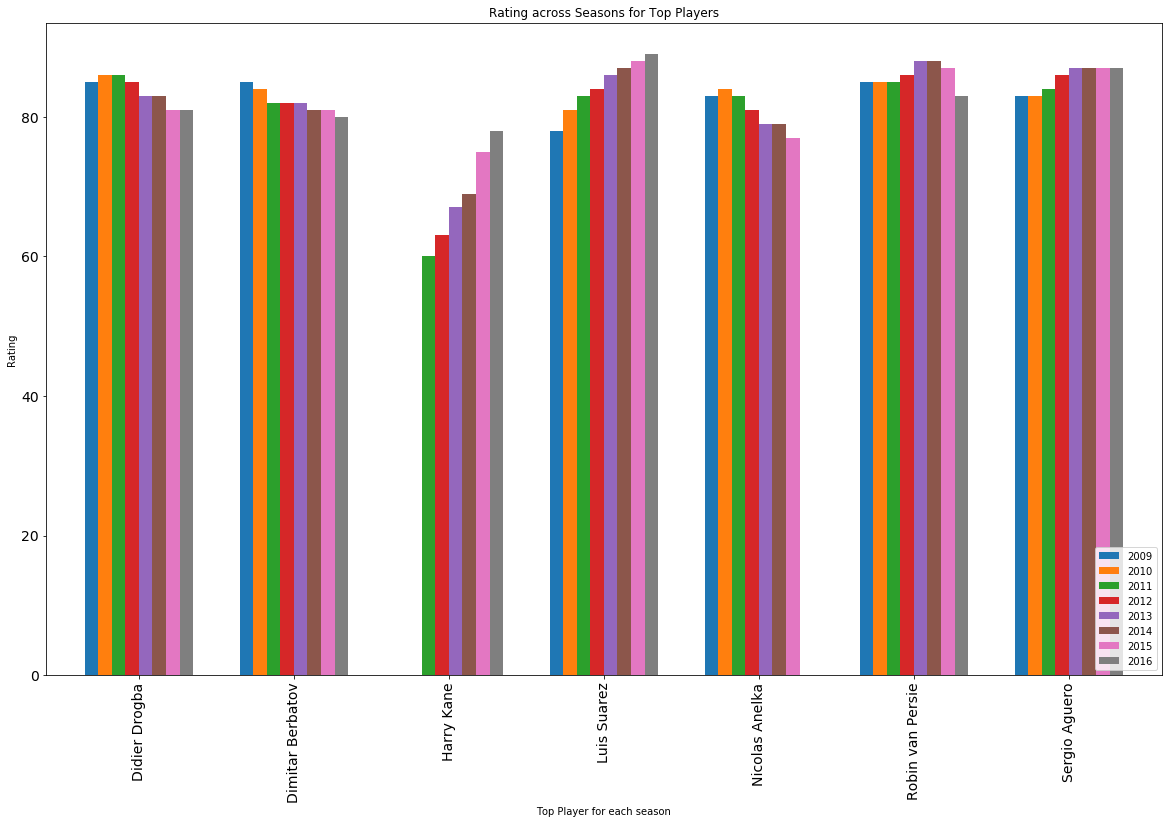

In [43]:
#print(player_overall_rating)
df.plot(kind='bar',title ="Rating across Seasons for Top Players", figsize=(20, 12), legend=True, fontsize=14, width=0.7)
plt.xlabel('Top Player for each season')
plt.ylabel('Rating')
plt.legend(loc='lower right')
plt.show()

 Based on the above analysis:
Following is the answers to the questions, we are not drawing conclusions though:
1. Which team won the EPL for the selected season?
We have done the test for 2009/2010 season and we found that Chelsea was the winner.
2. Which teams were releagated?
The teams that were relegated were 'Burnley', 'Hull City', 'Portsmouth' in this order for season 2009/2010. 
3. Which teams qualified for Champions League?
The teams that qualified for Champions League for the next season were 
 ['Chelsea', 'Manchester United', 'Arsenal', 'Tottenham Hotspur'] 
 for season 2010/2011.
4. Top 5 scorers for the season.
The player that scored the max goals for 2009/2010 season were 
 ['30822 - Didier Drogba--29', '30829 - Wayne Rooney--26', '23949 - Darren Bent--24', '38817 - Carlos Tevez--23', '30631 - Frank Lampard--22'].
 
 Team that has won the EPL maximum time across the seasons for which we have data is? (2009/10 - 2016-2016)
 Manchester United.
 The top player 
 

 